# load models

In [1]:
import os, jax, torch, numpy as np, matplotlib.pyplot as plt
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
from functools import partial
from src.JaxSimulation.dsp import BPS, bps, ddpll, cpr, mimoaf
import src.JaxSimulation.adaptive_filter as af
from src.JaxSimulation.core import MySignal, SigTime

from src.TorchDSP.dataloader import MyDataset
from torch.utils.data import DataLoader
from src.TorchDSP.baselines import DBP, get_omega, LinOp, DDLMS, CDC
from src.TorchSimulation.receiver import BER
from src.TorchDSP.dsp import TestDBP, LDBP
from src.TorchDSP.train_dbp import Test, Train
from src.TorchDSP.core import TorchSignal, TorchTime
from src.TorchDSP.loss import  MSE, SNR, Qsq


@partial(jax.jit, backend='cpu', static_argnums=(2,3,4,5))   
def DDLMS_jax(Rx, Tx, taps=32, sps=2, lead_symbols=20000, lr=(1/2**6, 1/2**6)):
    signal = MySignal(val=Rx, t=SigTime(0,0,sps), Fs=0)
    truth = MySignal(val=Tx, t=SigTime(0,0,1), Fs=0)
    model = mimoaf(taps=taps, train=lambda n: n<lead_symbols, mimofn=af.ddlms, learnable=False, mimokwargs={'lr_w': lr[0], 'lr_f':lr[1], 'lr_b':0})
    z, state = model.init_with_output(jax.random.PRNGKey(0), signal, truth, True)
    return z


def DSP(Rx, Tx, info, step=25, xi=0, lr=(1/2**6, 1/2**6), taps=32, calc_N=40000):
    '''
    Rx, Tx, info: [Nsymb*sps, Nmodes], [Nsymb, Nmodes], [4]
    '''
    dbp = DBP(Rx.to('cuda:0'), 2000e3, 2000e3//step, Fs=info[2:3].to('cuda:0'), power_dbm=info[0:1].to('cuda:0')+xi)
    y = DDLMS_jax(dbp.to('cpu').numpy(), Tx.numpy(), taps=taps, lr=lr)
    output = torch.tensor(jax.device_get(y.val))
    discard = (output.shape[0] - calc_N)//2
    return np.mean(BER(output[discard:-discard], Tx[y.t.start:y.t.stop][discard:-discard])['Qsq']), (output, Tx[y.t.start:y.t.stop])


def MetaDSP(Rx, Tx, info, lr=(1/2**6, 1/2**6), step=5, ntaps=401, taps=32, calc_N=40000, device='cuda:0', train_Rs='40', train_Nch='1'):
    '''
    Rx, Tx, info: [Nsymb*sps, Nmodes], [Nsymb, Nmodes], [4]
    '''
    dic = torch.load(f'_models/A_MetaDSP_R1/MetaDSP_Nmodes{Rx.shape[-1]}_step{step}_train{train_Rs}G_nch{train_Nch}/19.pth')
    net = LDBP(dic['dbp_info'])
    net.load_state_dict(dic['dbp_param'])
    net = net.to('cuda:0')
    net.set_ntaps(ntaps)
    net.cuda()
    # DBP
    signal = TorchSignal(val=Rx[None,:], t=TorchTime(0,0,2)).to(device)
    symb = TorchSignal(val=Tx[None,:], t=TorchTime(0,0,1)).to(device)
    info = info[None,:].to(device)
    with torch.no_grad():
        y = net(signal, info)
    
    # ADF
    sig_in = jax.numpy.array(y.val[0].cpu().numpy())
    symb_in = jax.numpy.array(symb.val[0, y.t.start//y.t.sps:y.t.stop//y.t.sps].cpu().numpy())
    z = DDLMS_jax(sig_in, symb_in, taps=taps, lr=lr)

    # metric
    ber_discard = (z.val.shape[0] - calc_N)//2
    z1 = torch.tensor(jax.device_get(z.val[ber_discard:-ber_discard]))
    z2 = torch.tensor(jax.device_get(symb_in[z.t.start:z.t.stop][ber_discard:-ber_discard]))
    mse = MSE(z1, z2)
    ber = np.mean(BER(z1, z2)['BER'])
    metric = {'MSE': mse, 'BER': ber, 'Qsq': Qsq(ber)} 

    return metric['Qsq'], (z1,z2)


def FDBPDSP(Rx, Tx, info, lr=(1/2**6, 1/2**6), step=5, train_Rs=40, train_Nch=1, taps=32, calc_N=40000, device='cuda:0'):
    '''
    Rx, Tx, info: [Nsymb*sps, Nmodes], [Nsymb, Nmodes], [4]
    '''
    dic = torch.load(f'_models/A_MetaDSP_R1/FDBP_Nmodes{Rx.shape[-1]}_{step}_{train_Rs}G_{train_Nch}ch_Pch[-2, 0, 2, 4]/19.pth')
    net = LDBP(dic['dbp_info'])
    net.load_state_dict(dic['dbp_param'])
    net = net.to('cuda:0')
    net.cuda()
    # DBP
    signal = TorchSignal(val=Rx[None,:], t=TorchTime(0,0,2)).to(device)
    symb = TorchSignal(val=Tx[None,:], t=TorchTime(0,0,1)).to(device)
    info = info[None,:].to(device)
    with torch.no_grad():
        y = net(signal, info)
    
    # ADF
    sig_in = jax.numpy.array(y.val[0].cpu().numpy())
    symb_in = jax.numpy.array(symb.val[0, y.t.start//y.t.sps:y.t.stop//y.t.sps].cpu().numpy())
    z = DDLMS_jax(sig_in, symb_in, taps=taps, lr=lr)

    # metric
    ber_discard = (z.val.shape[0] - calc_N)//2
    z1 = torch.tensor(jax.device_get(z.val[ber_discard:-ber_discard]))
    z2 = torch.tensor(jax.device_get(symb_in[z.t.start:z.t.stop][ber_discard:-ber_discard]))
    mse = MSE(z1, z2)
    ber = np.mean(BER(z1, z2)['BER'])
    metric = {'MSE': mse, 'BER': ber, 'Qsq': Qsq(ber)} 

    return metric['Qsq'], (z1,z2)


def Q_path(Rx, Tx, Ntest=10000, stride=10000):
    Q = []
    for t in np.arange(0, Rx.shape[-2] - Ntest, stride):
        Q.append(np.mean(BER(Rx[t:t+Ntest], Tx[t:t+Ntest])['Qsq']))
    return Q

def get_data(Nch, Rs, Pch, Nmodes, Nsymb=80000):
    if Nmodes == 1: assert Nsymb <= 99900
    data = MyDataset('dataset_A800/test.h5', Nch=[Nch], Rs=[Rs], Pch=[Pch], Nmodes=Nmodes, truncate=0,
                 window_size=Nsymb, strides=1, Nwindow=1, Tx_window=True, pre_transform='Rx')
    return data.__getitem__(0)

import pandas as pd
def max_table(results):
    df = pd.DataFrame(results)
    best_results = df.loc[df.groupby(['Rs', 'Nch'])['Qsq'].idxmax()]
    pivot_table = best_results.pivot_table(index='Rs', columns='Nch', values='Qsq')
    return pivot_table

Import Time: 0.11s


In [21]:
def Qp_Nch(Nch):
    Q = []
    for pch in range(-3, 8):
        Rx, Tx, info = get_data(21, 80, pch, 2)
        q = FDBPDSP(Rx, Tx, info, lr=(1/2**6, 1/2**6), step=5, train_Rs=80, train_Nch=Nch, taps=32, calc_N=40000, device='cuda:0')[0]
        Q.append(q)
    return Q

def Qp_Rs(Rs):
    Q = []
    for pch in range(-3, 8):
        Rx, Tx, info = get_data(21, 80, pch, 2)
        q = FDBPDSP(Rx, Tx, info, lr=(1/2**6, 1/2**6), step=5, train_Rs=Rs, train_Nch=1, taps=32, calc_N=40000, device='cuda:0')[0]
        Q.append(q)
    return Q

In [12]:
Qs = [Qp_Nch(1), Qp_Nch(5), Qp_Nch(21)]
names = ['train on Nch = 1', 'train on Nch = 5', 'train on Nch = 21']

plt.figure(figsize=(10,5), dpi=400)
for i in range(3):
    plt.plot(range(-3, 8), Qs[i], '--o', label=names[i])

plt.xlabel('Pch')
plt.ylabel('Q')
import numpy as np
plt.title('Qsq vs power (Rs=80G, Nch=21)')
plt.ylim(6, 9)
plt.grid()
plt.yticks(np.arange(6, 9.0, 0.2))
plt.legend()

In [23]:
Qs = [Qp_Rs(40), Qp_Rs(80), Qp_Rs(160)]
names = ['train on Rs = 40G', 'train on Rs = 80G', 'train on Rs = 160G']

plt.figure(figsize=(10,5), dpi=400)
for i in range(3):
    plt.plot(range(-3, 8), Qs[i], '--o', label=names[i])

plt.xlabel('Pch')
plt.ylabel('Q')
import numpy as np
plt.title('Qsq vs power (Rs=80G, Nch=21)')
plt.ylim(6, 9)
plt.grid()
plt.yticks(np.arange(6, 9.0, 0.2))
plt.legend()

In [12]:
data = MyDataset('dataset_A800/test.h5', Nch=[11], Rs=[160], Pch=[1], Nmodes=1, truncate=0,
                 window_size=99970, strides=1, Nwindow=1, Tx_window=True, pre_transform='Rx_CDCDDLMS(taps=32,lr=[0.015625, 0.0078125])')
Rx,Tx,info = data.__getitem__(0)
print('Rx, Tx, info', Rx.shape, Tx.shape, info.shape)
print('info: P, Fi, Fs, Nch')

# plt.plot(Q_path(Rx[2000:-20000],Tx[2000:-20000], stride=1000, Ntest=50000), '-o')

Rx, Tx, info torch.Size([99970, 1]) torch.Size([99970, 1]) torch.Size([4])
info: P, Fi, Fs, Nch


In [49]:
Rx, Tx, info = get_data(21, 160, 6, 2, Nsymb=200000)

Q, (z1,z2) = DSP(Rx, Tx, info, step=25*32, xi=0, lr=(1/2**6,1/2**6))
Q1 = Q_path(z1,z2, stride=10000, Ntest=20000)

Q, (z1,z2) = DSP(Rx, Tx, info, step=25*32, xi=0, lr=(1/2**6, 0))
Q2 = Q_path(z1,z2, stride=10000, Ntest=20000)

In [50]:
np.mean(Q2[1:])

8.165066

In [51]:
np.mean(Q1[1:])

8.264866

(8.0, 9.5)

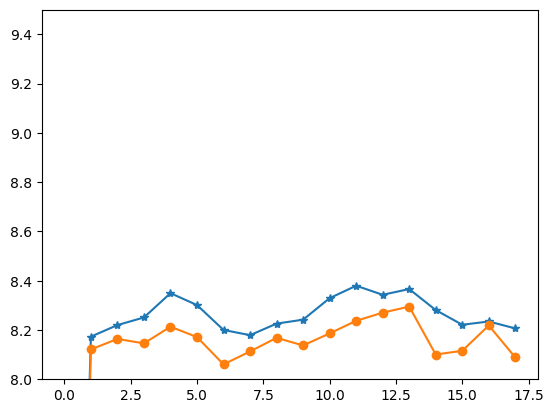

In [52]:
plt.plot(Q1, '-*')
plt.plot(Q2, '-o')

plt.ylim(8, 9.5)

In [53]:
# CDC + XPM
Q = DSP(Rx, Tx, info, step=1, xi=-100)[0]
print('CDC + XPM: ', Q)

# CDC + LMS
Q = DSP(Rx, Tx, info, step=1, xi=-100, lr=(1/2**6, 0))[0]
print('CDC + LMS: ', Q)

# DBP + XPM
Q = np.max([DSP(Rx, Tx, info, step=25*8, xi=xi, taps=32, lr=(1/2**6, 1/2**6))[0] for xi in range(-10,1)])
print('DBP + XPM: ', Q)

# DBP + LMS
Q = np.max([DSP(Rx, Tx, info, step=25*8, xi=xi, taps=32, lr=(1/2**6, 0))[0] for xi in range(-10,1)])
print('DBP + LMS: ', Q)


CDC + XPM:  6.4988217
CDC + LMS:  6.2972527
DBP + XPM:  7.1010656
DBP + LMS:  6.9400287


In [108]:
Q = MetaDSP(Rx, Tx, info, ntaps=401, step=5, taps=32)[0]
print('MetaDSP step = 5: ', Q)

Q = MetaDSP(Rx, Tx, info, ntaps=201, step=25, taps=32)[0]
print('MetaDSP step = 25: ', Q)

MetaDSP step = 5:  7.832465115729546
MetaDSP step = 25:  8.044717646054407


In [109]:
Q = FDBPDSP(Rx, Tx, info, step=5, train_Rs=160, train_Nch=21, taps=32)[0]
print('FDBPDSP: ', Q)

FDBPDSP:  7.826155933871974


In [461]:
stps = [1,2,4,8]
Qs = [[DSP(Rx, Tx, info, step=step, xi=xi)[0] for xi in np.arange(-15,5)] for step in [25*t for t in stps]]

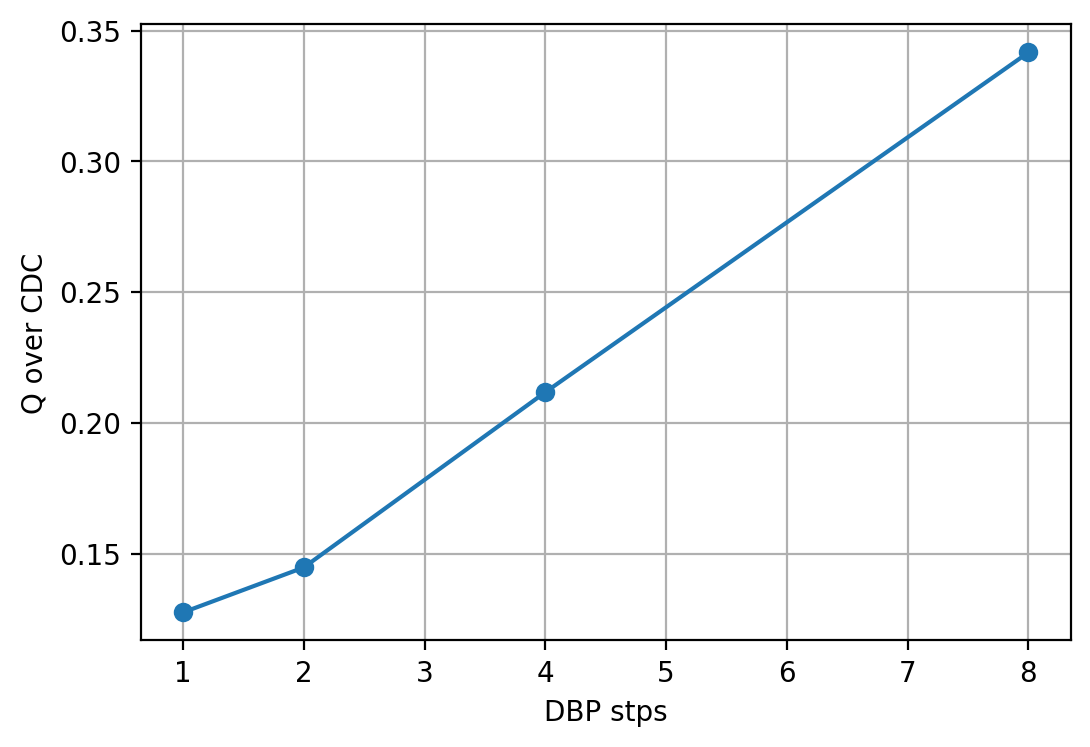

In [464]:
plt.figure(dpi=200, figsize=(6,4))
Qcdc = DSP(Rx, Tx, info, step=1, xi=-100)[0]
plt.plot(stps, [np.max(Q) - Qcdc for Q in Qs], '-o')
plt.xlabel('DBP stps')
plt.ylabel('Q over CDC')
plt.grid()

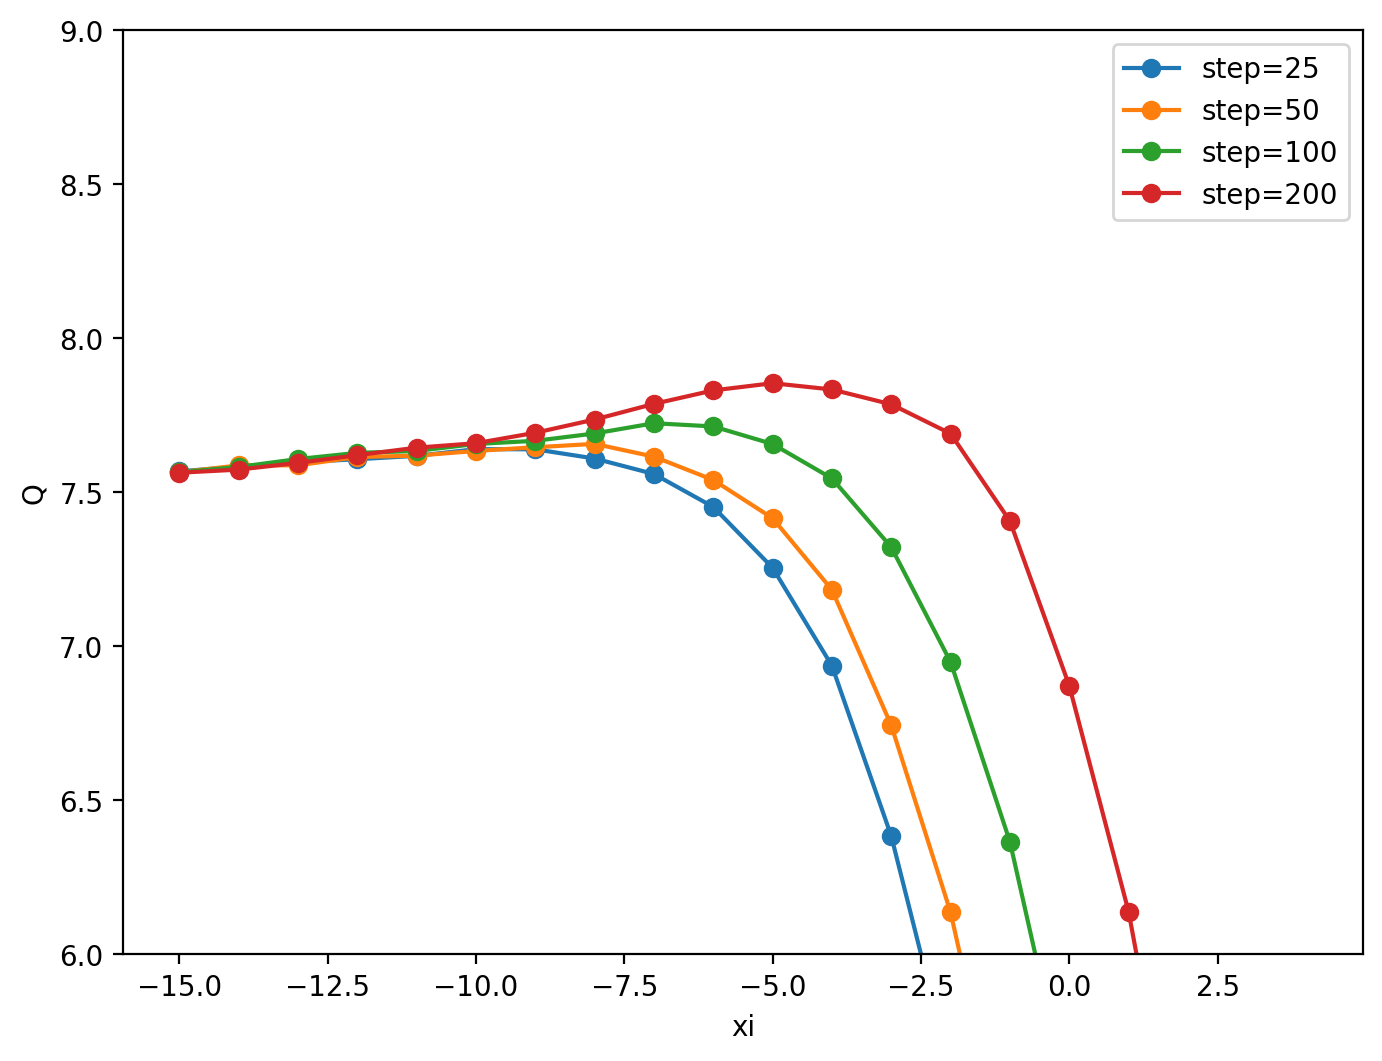

In [466]:
plt.figure(figsize=(8,6), dpi=200)
for i, Q in enumerate(Qs):
    plt.plot(np.arange(-15,5), Q, '-o', label=f'step={stps[i]*25}')
plt.ylim(6,9)
plt.xlabel('xi')
plt.ylabel('Q')
plt.legend()

# load results

In [1]:
import pandas as pd
import re

# 定义文件路径
file_path = '_outputs/paper_txt/Final_result.txt'

# 定义列名
columns = ['Nmodes', 'Rs', 'Nch', 'Pch', 'Method', 'Value']

# 初始化一个空列表来保存数据
data = []

# 打开文件并逐行读取
with open(file_path, 'r') as file:
    for line in file:
        # 去除行末尾的换行符
        line = line.strip()
        
        # 使用正则表达式匹配并提取数据
        match = re.match(r'Nmodes=(\d+), Rs=(\d+), Nch=(\d+), Pch=(-?\d+), (.*): (-?[\d.]+|inf|-inf)', line)
        if match:
            nmodes = int(match.group(1))
            rs = int(match.group(2))
            nch = int(match.group(3))
            pch = int(match.group(4))
            method = match.group(5).strip()
            value = match.group(6)
            # 处理值为'inf'的情况
            value = float(value) if value != 'inf' else float('inf')
            
            # 将数据添加到列表
            data.append([nmodes, rs, nch, pch, method, value])
        else:
            print(line)

# 创建DataFrame
df = pd.DataFrame(data, columns=columns)

# 打印DataFrame以查看结果
print(df)

# 如果需要保存到文件，可以使用以下代码
# df.to_csv('_outputs/paper_txt/processed_result.csv', index=False)


      Nmodes   Rs  Nch  Pch                               Method     Value
0          2   40    1   -3                                  CDC  8.059405
1          2   40    1   -3                           DBP stps=1  8.294577
2          2   40    1   -3                           DBP stps=2  8.316214
3          2   40    1   -3                           DBP stps=4  8.362030
4          2   40    1   -3                           DBP stps=6  8.388072
...      ...  ...  ...  ...                                  ...       ...
7633       1  160   11    4  FDBP step=25 train on Rs=160G Nch=1  7.974447
7634       1  160   11    5   FDBP step=5 train on Rs=160G Nch=1  5.803586
7635       1  160   11    5  FDBP step=25 train on Rs=160G Nch=1  6.902381
7636       1  160   11    6   FDBP step=5 train on Rs=160G Nch=1  4.304720
7637       1  160   11    6  FDBP step=25 train on Rs=160G Nch=1  5.514559

[7638 rows x 6 columns]


In [9]:
import pandas as pd, matplotlib.pyplot as plt   
import seaborn as sns

def plot_table(pivot_table, path='test', save=False, title='test'):
    plt.figure(figsize=(6,4), dpi=400)
    sns.heatmap(pivot_table, annot=True, cmap='Blues', fmt=".2f", vmin=6, vmax=13)
    plt.title(title)
    plt.xlabel('WDM channels')
    plt.ylabel('symbol rate (G)')
    if save: plt.savefig(path)

def Qmax_table(Nmodes, method):
    df_term = df[(df['Nmodes'] == Nmodes) & (df['Method'] == method)]

    # 分组并找到每组中Value的最大值
    result = df_term.groupby(['Rs', 'Nch'])['Value'].max().reset_index()

    # 重命名列
    result.rename(columns={'Value': 'Max_Value'}, inplace=True)
    table = result.pivot_table(index='Rs', columns='Nch', values='Max_Value')

    # 将 'inf' 替换为 13
    table.replace(float('inf'), 13, inplace=True)
    return table

# def rename(method):
#     if 'stps' in method:
#         stps = int(method.split('=')[1])
#         return f'DBP step={stps * 25} (stps = {stps})' 
#     elif 'MetaDSP' in method:
#         return  method.split(',')[0] + ' train on Rs=40G, Nch=1'
#     else:
#         return method
    
def rename(method):
    if 'stps' in method:
        stps = int(method.split('=')[1])
        return f'DBP step={stps * 25} (stps = {stps})' 
    elif method == 'MetaDSP step=5, ntaps=401':
        return  'Meta-DSP (step = 5)'
    elif method == 'MetaDSP step=25, ntaps=201':
        return  'Meta-DSP (step = 25)'
    elif method == 'FDBP step=5 train on Rs=40G Nch=1':
        return 'FDBP (step=5)'
    elif method == 'FDBP step=25 train on Rs=40G Nch=1':
        return 'FDBP (step=25)'
    else:
        return method

In [8]:
df['Method'].unique()

array(['CDC', 'DBP stps=1', 'DBP stps=2', 'DBP stps=4', 'DBP stps=6',
       'DBP stps=8', 'DBP stps=16', 'DBP stps=24', 'DBP stps=32',
       'MetaDSP step=5, ntaps=401', 'MetaDSP step=25, ntaps=201',
       'FDBP step=5', 'FDBP step=25', 'FDBP step=5 train on Rs=40G Nch=1',
       'FDBP step=25 train on Rs=40G Nch=1',
       'FDBP step=5 train on Rs=80G Nch=1',
       'FDBP step=25 train on Rs=80G Nch=1',
       'FDBP step=5 train on Rs=160G Nch=1',
       'FDBP step=25 train on Rs=160G Nch=1'], dtype=object)

## plot table

In [ ]:
for Nmodes in [1,2]:
    for method in df['Method'].unique():
        if 'MetaDSP' in method or 'FDBP' in method: 
            title = rename(method)
            plot_table(Qmax_table(Nmodes, method), title=title, save=True, path=f'_outputs/R1_img/{method}_Nmodes{Nmodes}.png')

## plot Q-P

In [5]:
df['Method']

0                                       CDC
1                                DBP stps=1
2                                DBP stps=2
3                                DBP stps=4
4                                DBP stps=6
                       ...                 
7633    FDBP step=25 train on Rs=160G Nch=1
7634     FDBP step=5 train on Rs=160G Nch=1
7635    FDBP step=25 train on Rs=160G Nch=1
7636     FDBP step=5 train on Rs=160G Nch=1
7637    FDBP step=25 train on Rs=160G Nch=1
Name: Method, Length: 7638, dtype: object

In [4]:
df[(df['Nmodes'] == 2) & (df['Rs'] == 40) & (df['Nch'] == 21) & (df['Method'] == 'CDC')]['Value'].max()

8.014702796936035

In [5]:
Qmax_table(2,'FDBP step=5 train on Rs=40G Nch=1') - Qmax_table(2,'CDC')

Nch,1,3,5,21
Rs,,,,
40,1.101264,0.588652,0.530331,0.306141
80,-0.049974,0.006429,0.027289,0.040902
160,-1.419789,-1.073222,-1.305938,-1.012943


In [117]:
Qmax_table(2,'FDBP step=25 train on Rs=40G Nch=1') - Qmax_table(2,'CDC')

Nch,1,3,5,21
Rs,,,,
40,2.294934,1.112609,0.933447,0.523329
80,0.832122,0.606017,0.356733,0.455901
160,-5.110584,-4.737772,-5.174820,-4.961586


In [116]:
Qmax_table(2,'MetaDSP step=25, ntaps=201') - Qmax_table(2,'CDC')

Nch,1,3,5,21
Rs,,,,
40,2.065176,1.042745,0.909101,0.497324
80,1.220123,0.782978,0.546918,0.621487
160,0.931619,0.766323,0.599709,0.496792


In [115]:
Qmax_table(2,'MetaDSP step=5, ntaps=401') - Qmax_table(2,'CDC')

Nch,1,3,5,21
Rs,,,,
40,1.076493,0.571225,0.513019,0.282167
80,0.593781,0.480391,0.283794,0.306785
160,0.371062,0.370607,0.245682,0.231228


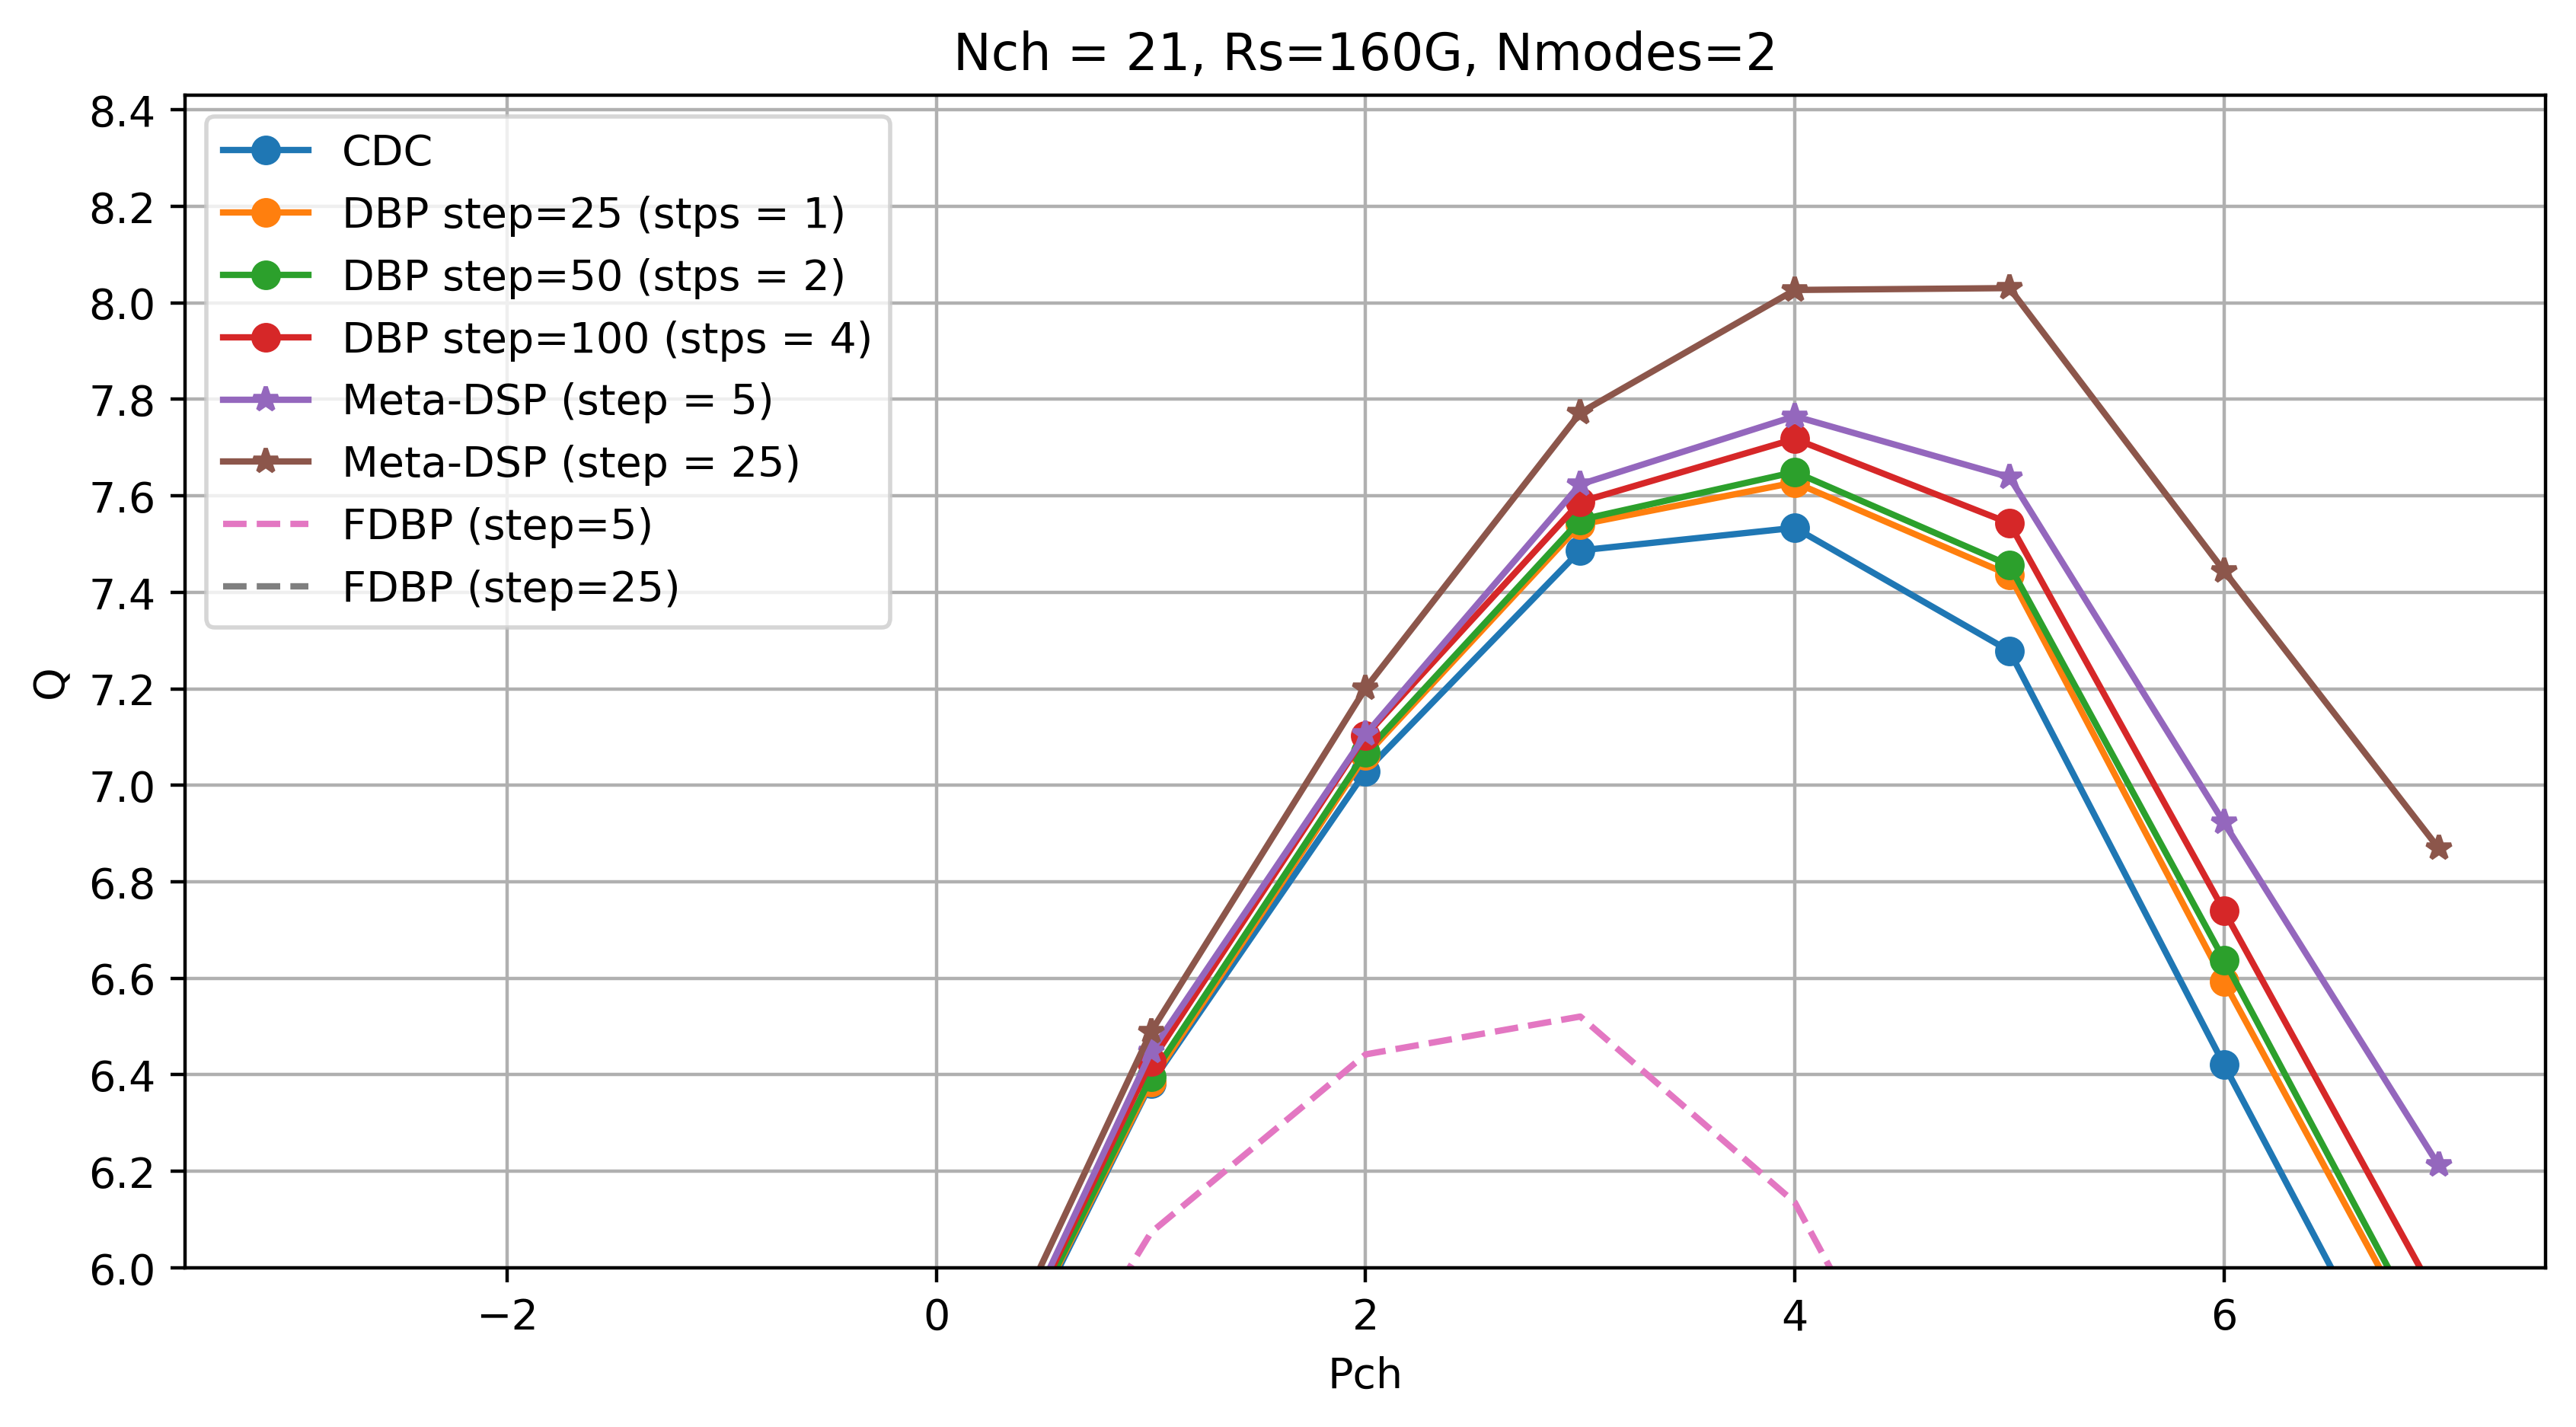

In [11]:
plt.figure(figsize=(10,5), dpi=400)

Nmodes = 2
Rs = 160
Nch = 21
method_list = ['CDC','DBP stps=1', 'DBP stps=2', 'DBP stps=4'] +  ['MetaDSP step=5, ntaps=401'] +\
    ['MetaDSP step=25, ntaps=201', 'FDBP step=5 train on Rs=40G Nch=1', 'FDBP step=25 train on Rs=40G Nch=1']

ymax = 0
for method in method_list:
    Qp = df[(df['Nmodes'] == Nmodes) & (df['Rs'] == Rs) & (df['Nch'] == Nch) & (df['Method'] == method)]
    ymax = max(ymax, Qp['Value'].max())

    label = rename(method)
    if 'MetaDSP' in method:
        plt.plot(Qp['Pch'], Qp['Value'], '-*', label=label)
    elif 'FDBP' in method:
        plt.plot(Qp['Pch'], Qp['Value'], '--', label=label)
    else:
        plt.plot(Qp['Pch'], Qp['Value'], '-o', label=label)

plt.xlabel('Pch')
plt.ylabel('Q')
import numpy as np

plt.ylim(6, ymax+0.4)
plt.yticks(np.arange(6, ymax+0.4, 0.2))
plt.title(f'Nch = {Nch}, Rs={Rs}G, Nmodes={Nmodes}')
plt.grid()
plt.legend()
# plt.savefig(f'_outputs/R1_img/Nmodes{Nmodes}_Rs{Rs}G_Nch{Nch}.png')

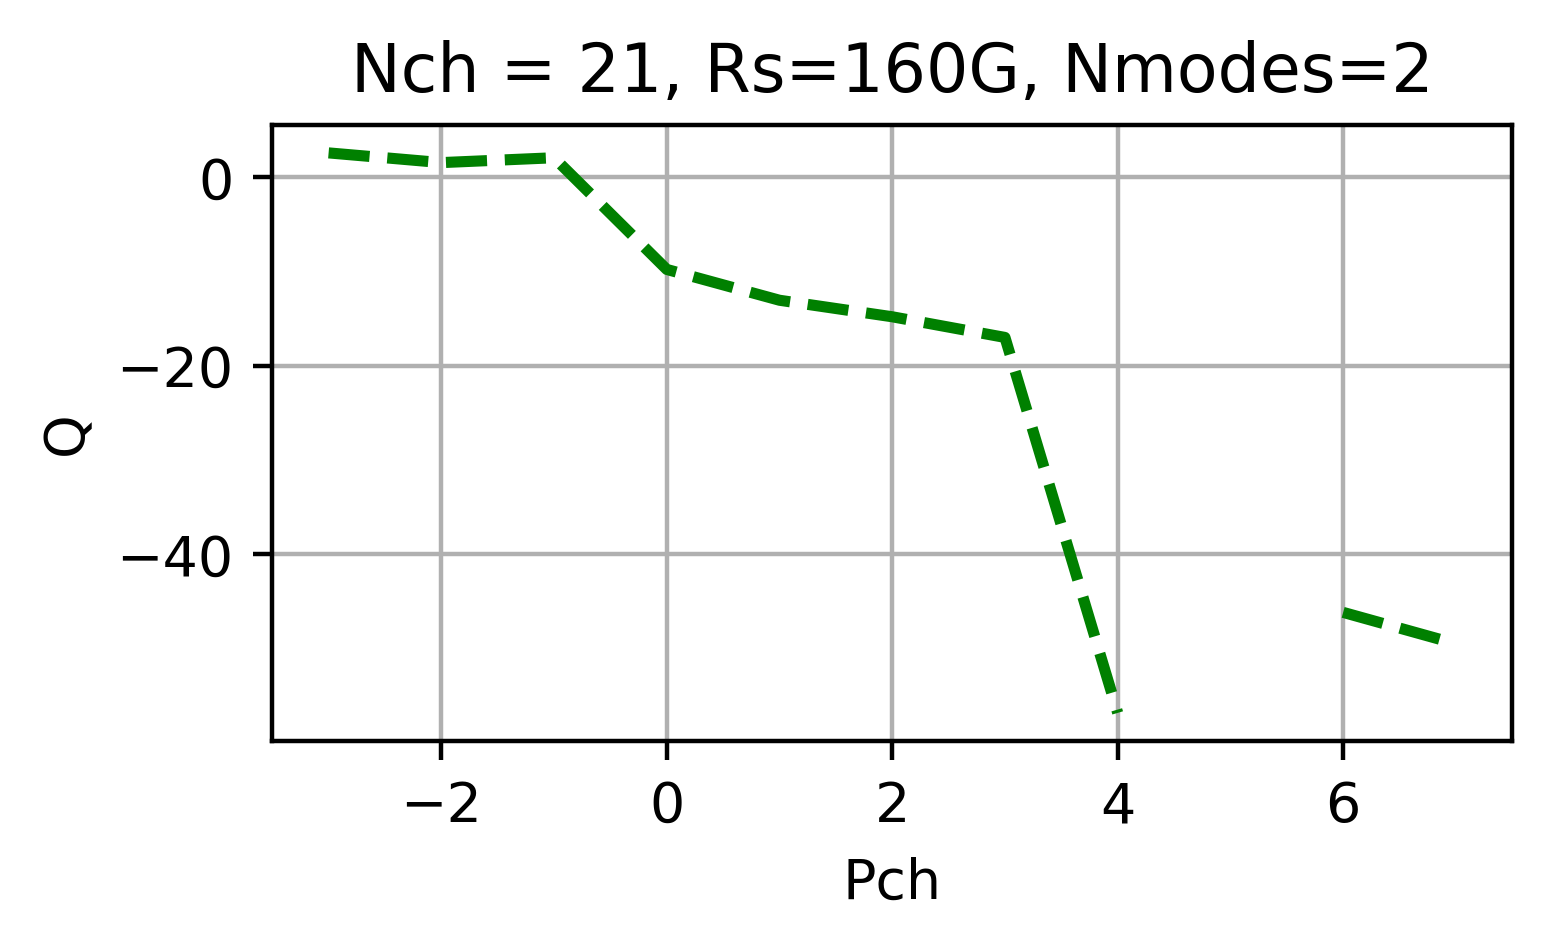

In [102]:
plt.figure(figsize=(4,2), dpi=400)

Nmodes = 2
Rs = 160
Nch = 21
method_list = ['FDBP step=25 train on Rs=40G Nch=1']

ymax = 0
for method in method_list:
    Qp = df[(df['Nmodes'] == Nmodes) & (df['Rs'] == Rs) & (df['Nch'] == Nch) & (df['Method'] == method)]
    ymax = max(ymax, Qp['Value'].max())

    label = rename(method)
    if 'MetaDSP' in method:
        plt.plot(Qp['Pch'], Qp['Value'], '-*', label=label)
    elif 'FDBP' in method:
        plt.plot(Qp['Pch'], Qp['Value'], '--', color='g', label=label,  linewidth=2)
    else:
        plt.plot(Qp['Pch'], Qp['Value'], '-o', label=label)

plt.xlabel('Pch')
plt.ylabel('Q')
import numpy as np
plt.title(f'Nch = {Nch}, Rs={Rs}G, Nmodes={Nmodes}')
plt.grid()
# plt.legend()
plt.savefig(f'_outputs/R1_img/Nmodes{Nmodes}_Rs{Rs}G_Nch{Nch}_long.png')

## plot N-filter

In [42]:
import torch, numpy as np, matplotlib.pyplot as plt
from src.TorchDSP.dsp import TestDBP, LDBP

def get_FDBP_Nfilter(Nmodes, step, train_Rs, train_Nch):
    dic = torch.load(f'_models/A_MetaDSP_R1/FDBP_Nmodes{Nmodes}_{step}_{train_Rs}G_{train_Nch}ch_Pch[-2, 0, 2, 4]/19.pth')
    net = LDBP(dic['dbp_info'])
    net.load_state_dict(dic['dbp_param'])
    net = net.to('cpu')
    return net.get_N_kernel(torch.ones(1,4)).squeeze().data


def get_MetaDSP_Nfilter(Nmodes, step, Rs):
    dic = torch.load(f'_models/A_MetaDSP_R1/MetaDSP_Nmodes{Nmodes}_step{step}_train40G_nch1/19.pth')
    net = LDBP(dic['dbp_info'])
    net.load_state_dict(dic['dbp_param'])
    net = net.to('cpu')
    return net.get_N_kernel(torch.tensor([[0,0,Rs*2e9,0]])).squeeze().data

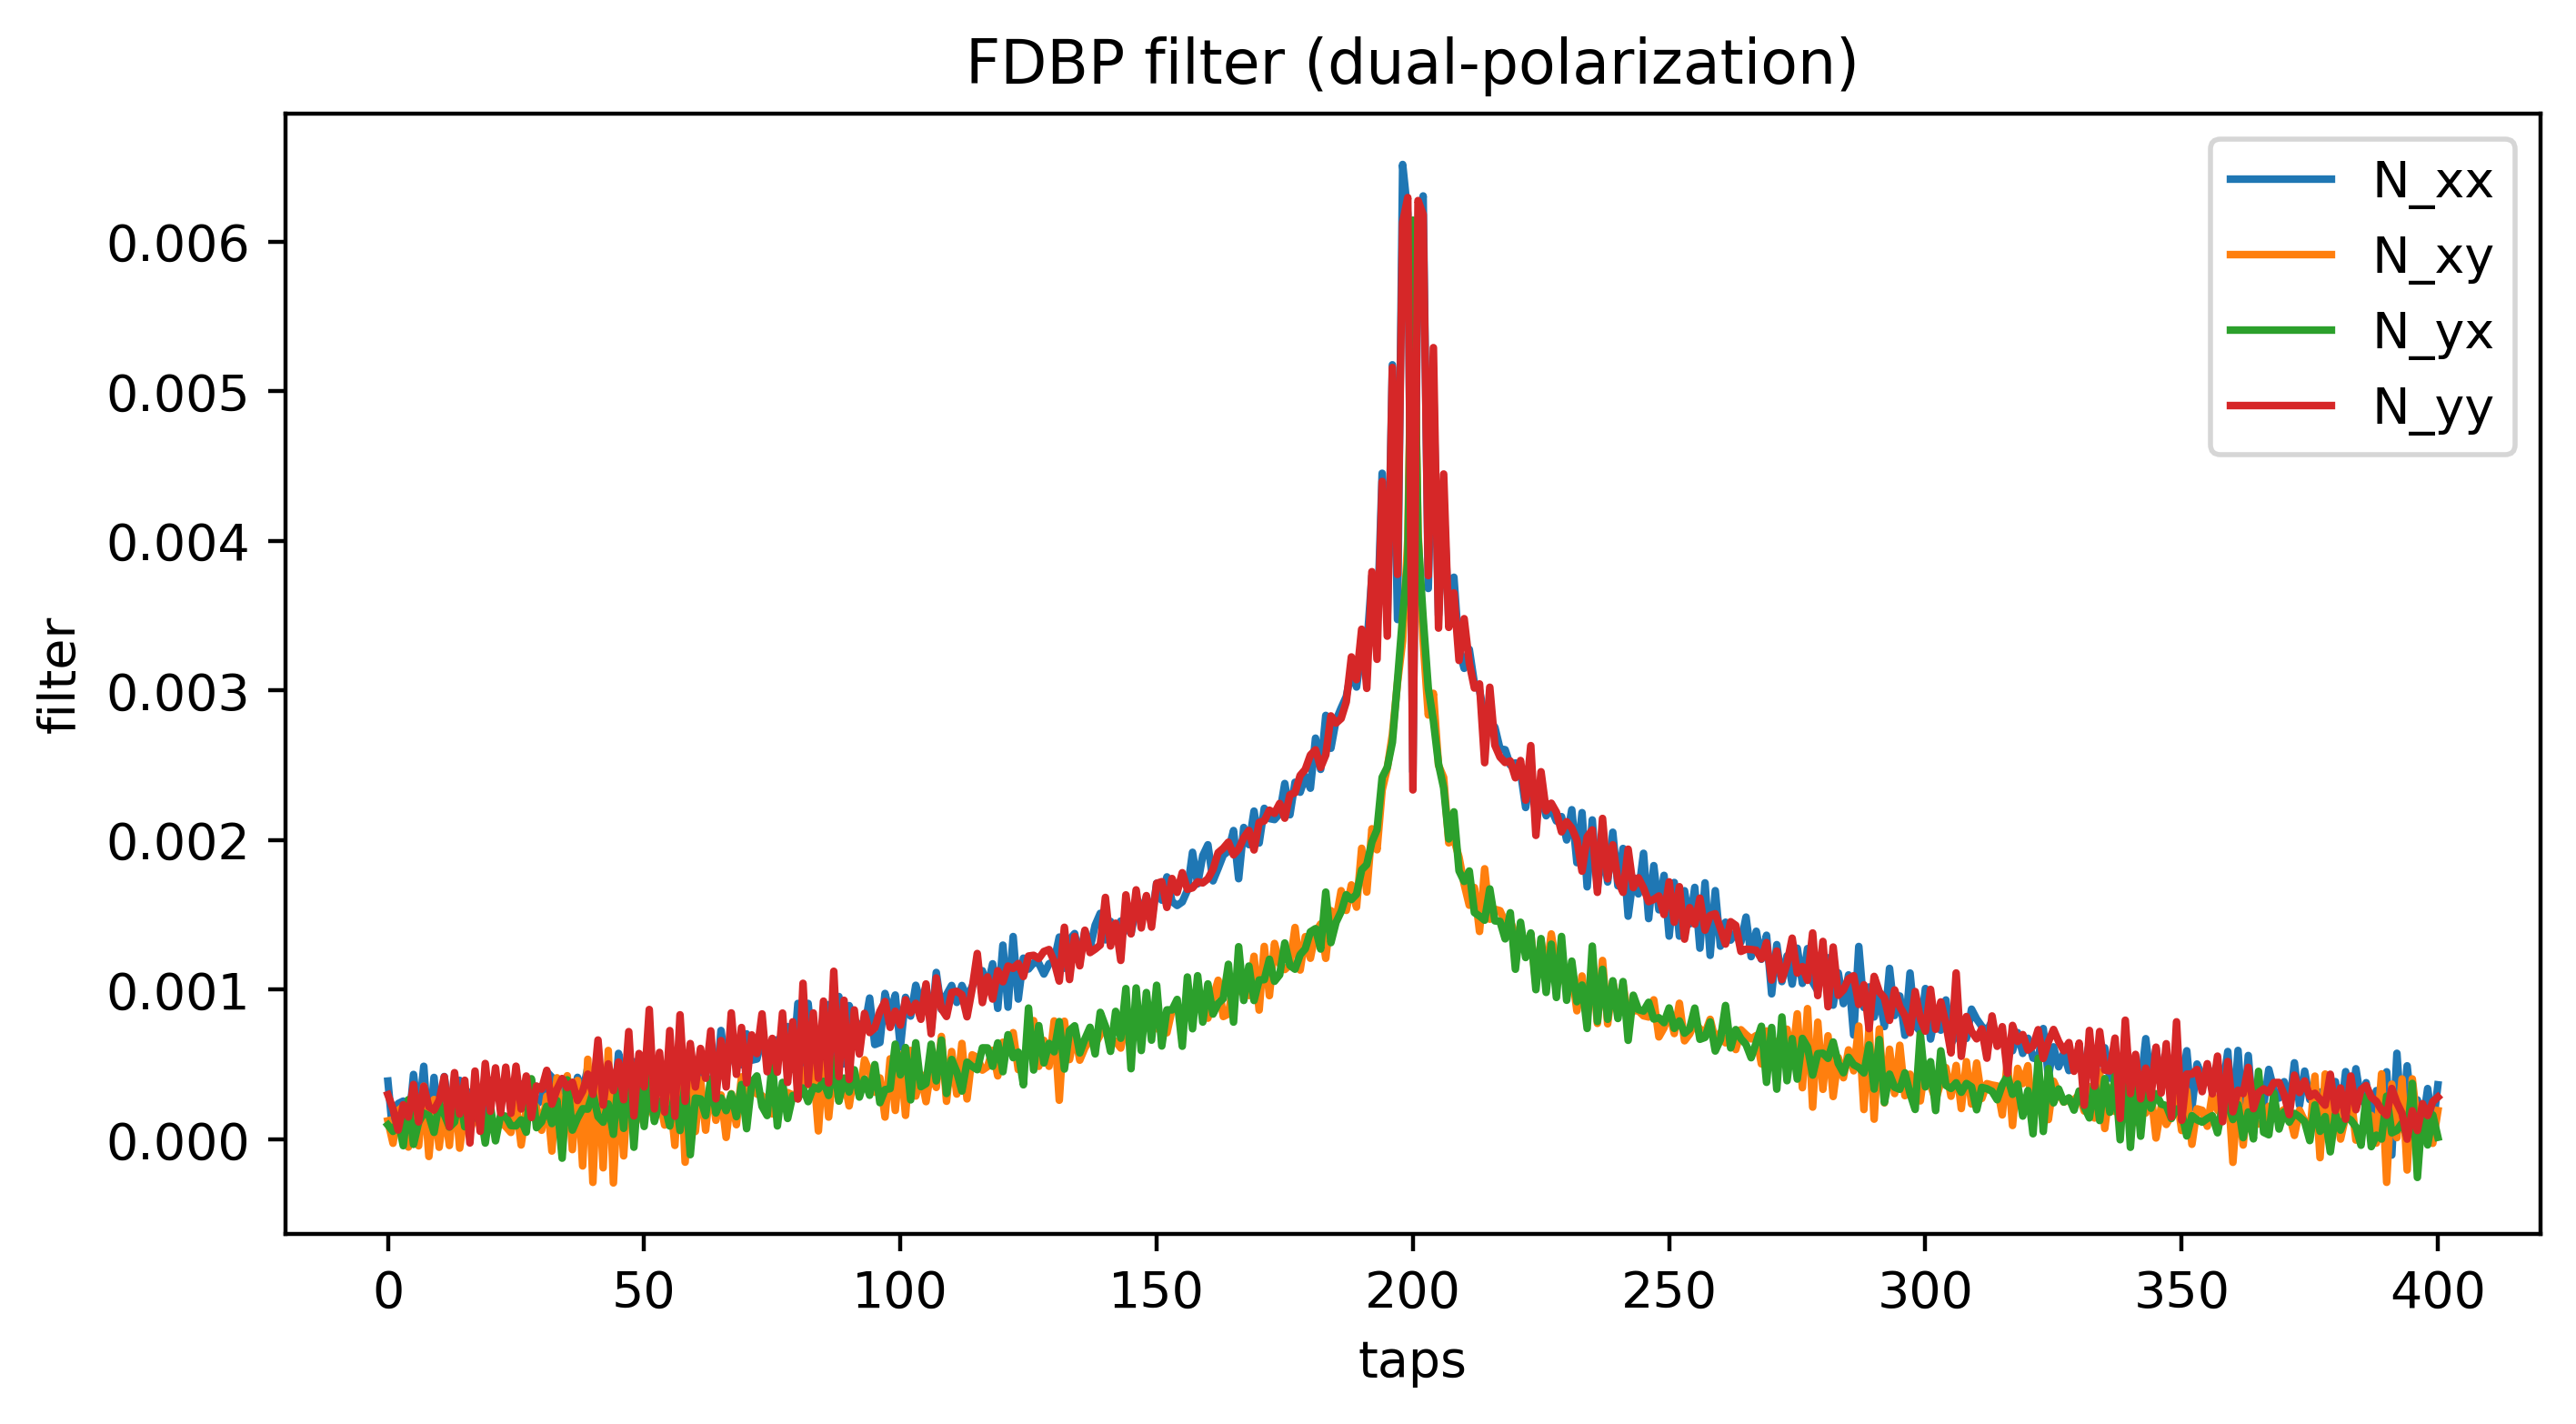

In [80]:
plt.figure(figsize=(8,4), dpi=400)
plt.plot(get_FDBP_Nfilter(2, 5, 80, 1)[0,0], label='N_xx')
plt.plot(get_FDBP_Nfilter(2, 5, 80, 1)[0,1], label='N_xy')
plt.plot(get_FDBP_Nfilter(2, 5, 80, 1)[1,0], label='N_yx')
plt.plot(get_FDBP_Nfilter(2, 5, 80, 1)[1,1], label='N_yy')
plt.xlabel('taps')
plt.ylabel('filter')
plt.legend()
plt.title('FDBP filter (dual-polarization)')
plt.savefig('_outputs/R1_img/FDBP_filter_dual.png')

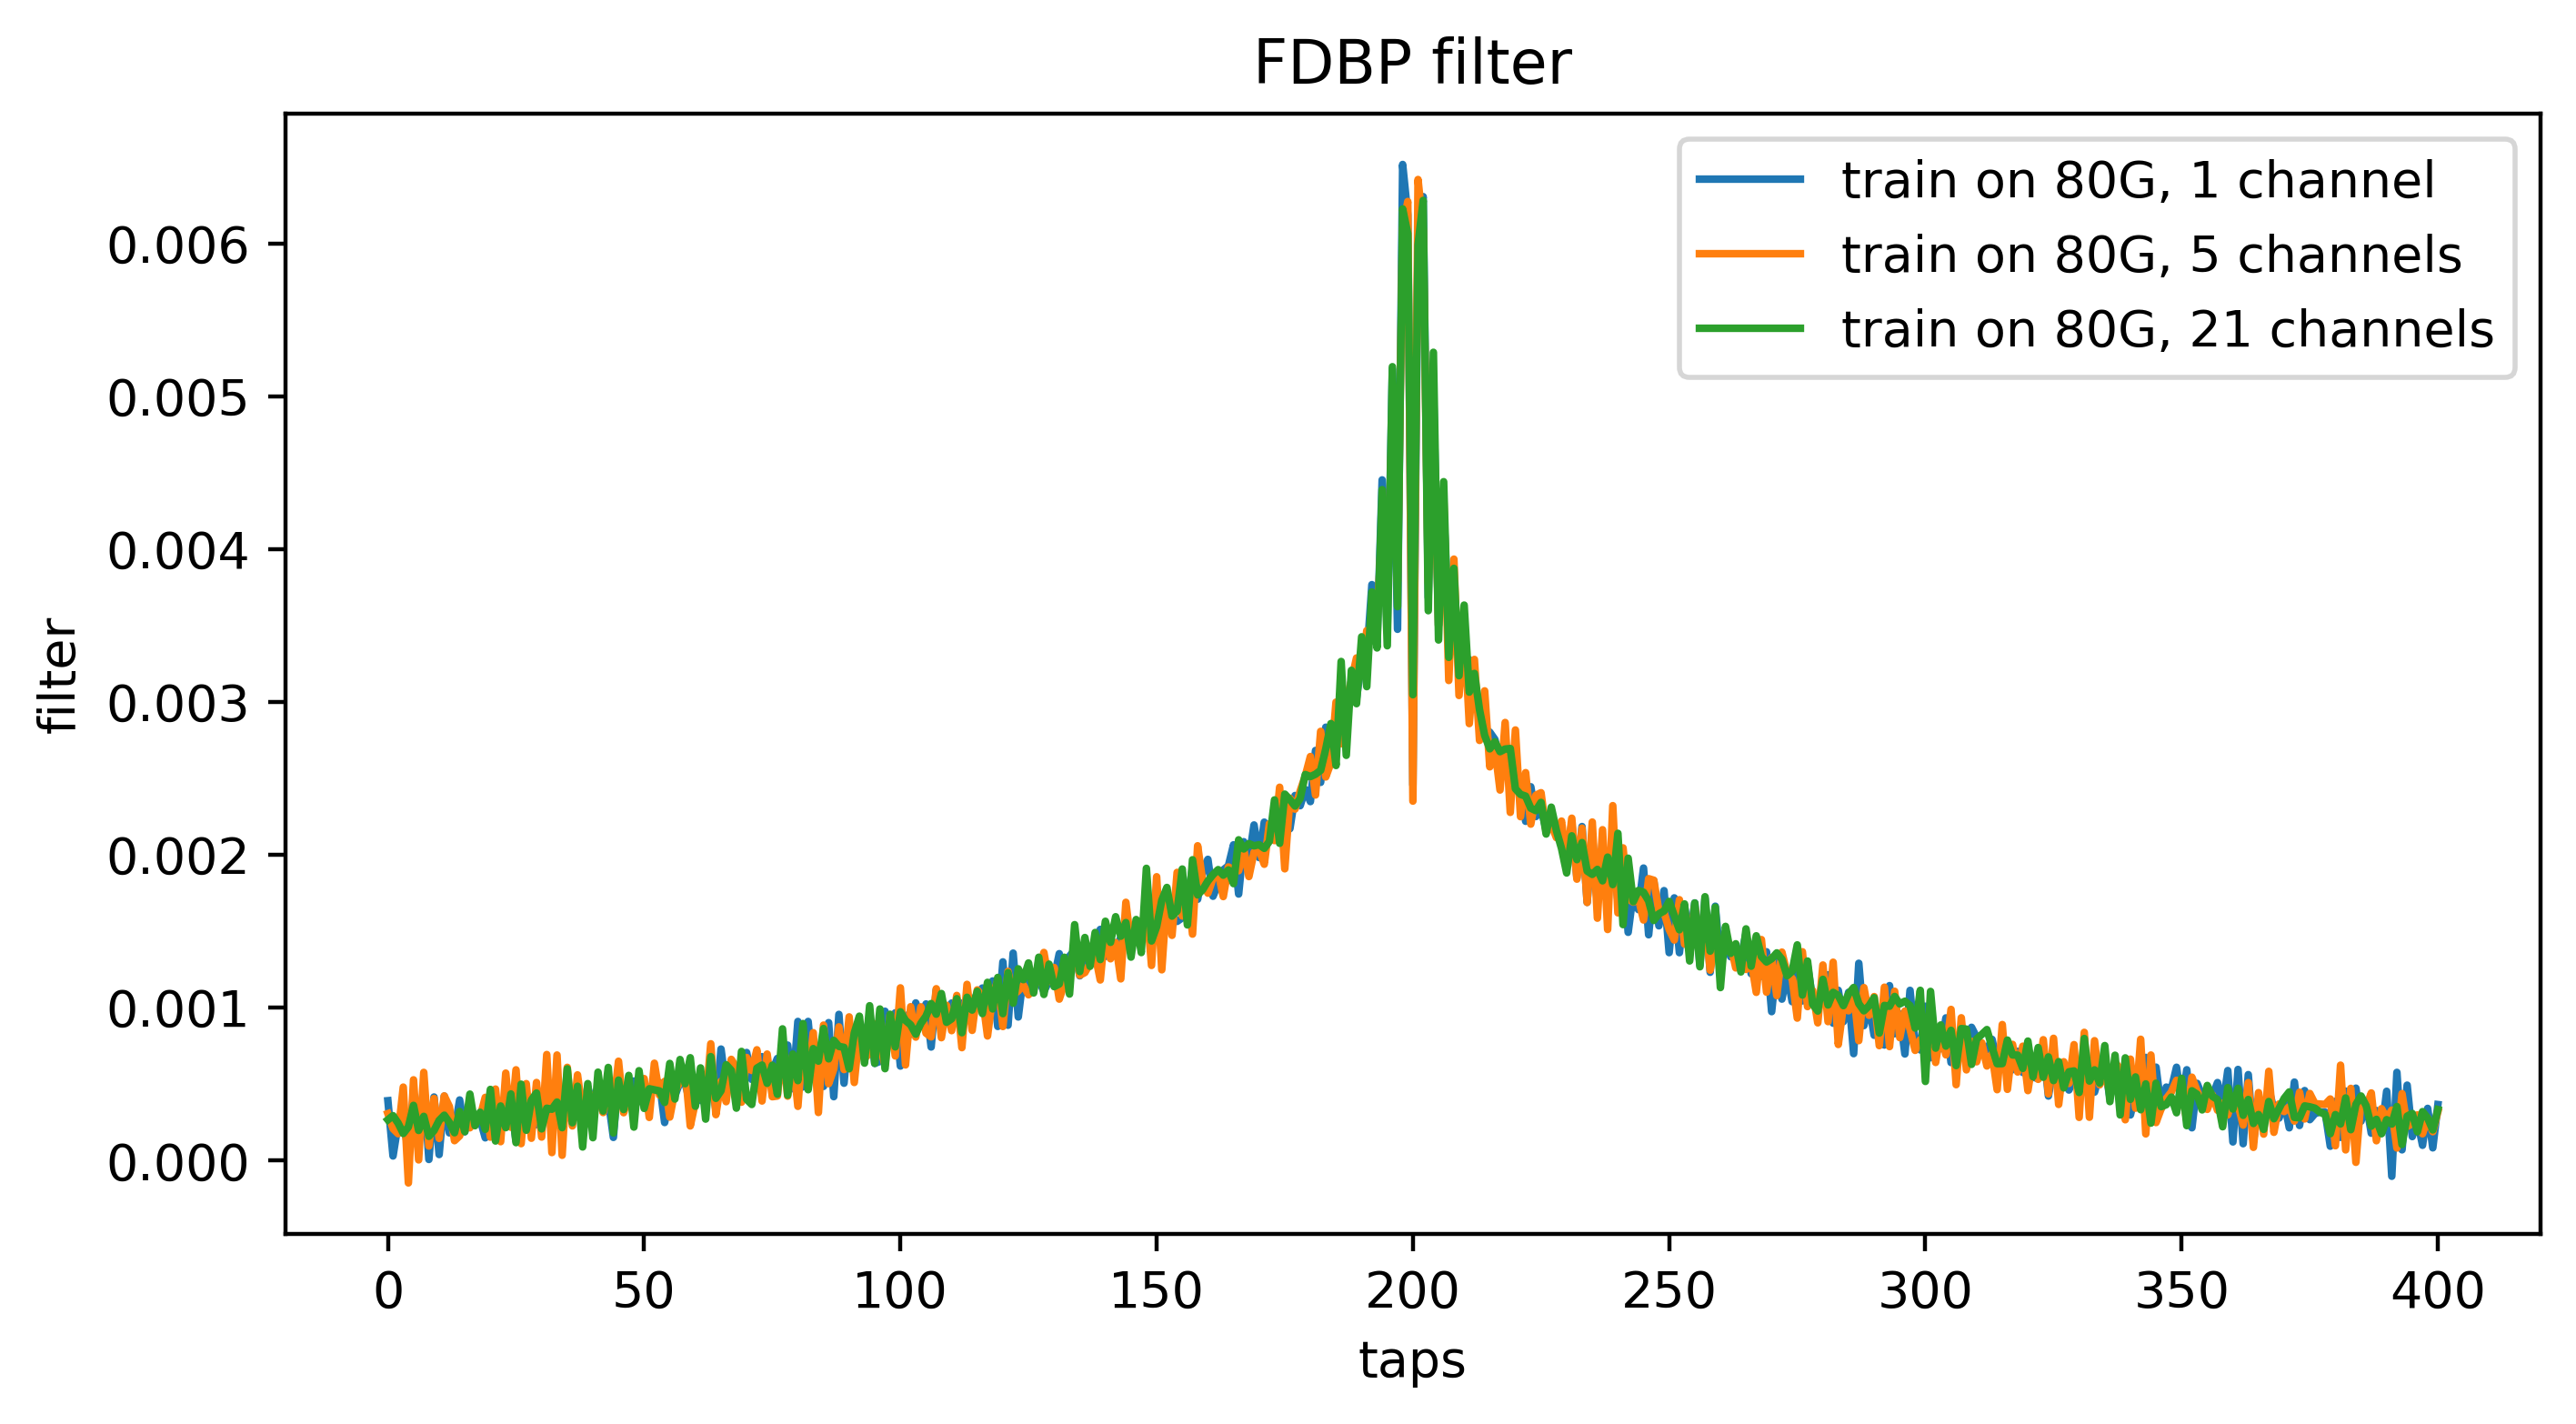

In [87]:
plt.figure(figsize=(8,4), dpi=400)
plt.plot(get_FDBP_Nfilter(2, 5, 80, 1)[0,0], label='train on 80G, 1 channel')
plt.plot(get_FDBP_Nfilter(2, 5, 80, 5)[0,0], label='train on 80G, 5 channels')
plt.plot(get_FDBP_Nfilter(2, 5, 80, 21)[0,0], label='train on 80G, 21 channels')
plt.xlabel('taps')
plt.ylabel('filter')
plt.legend()
plt.title('FDBP filter')
plt.savefig('_outputs/R1_img/FDBP_Nch.png')

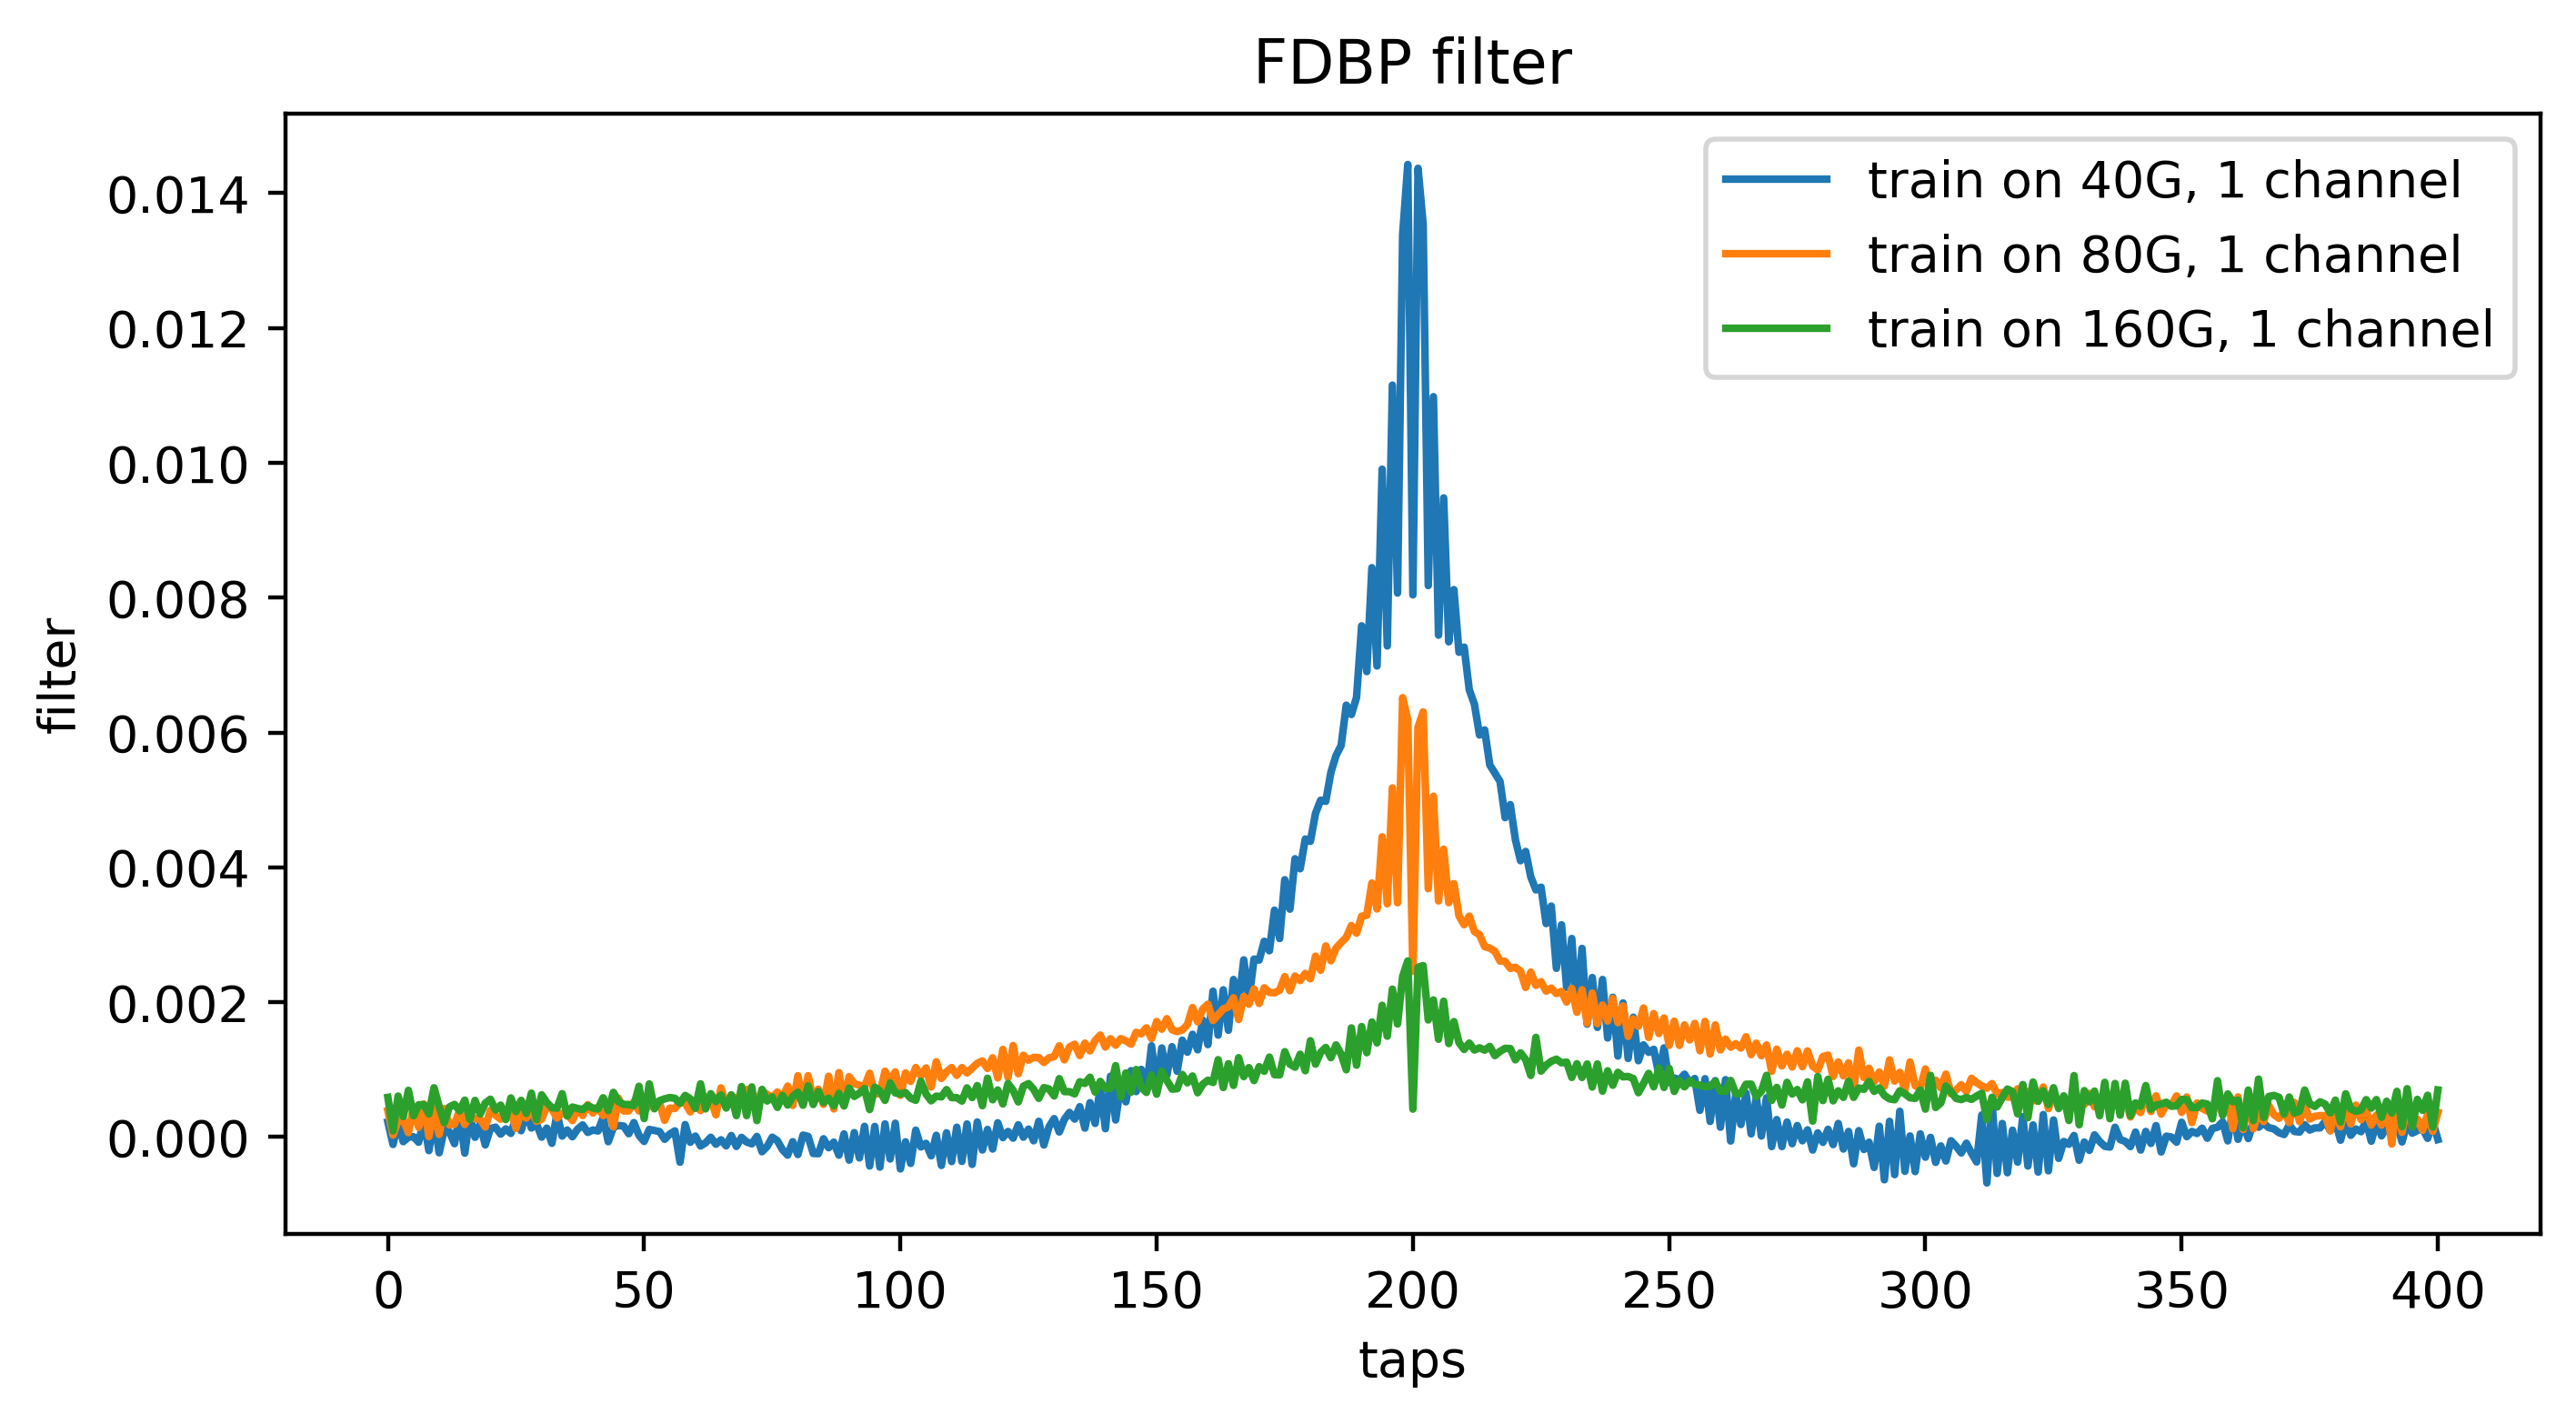

In [82]:
plt.figure(figsize=(8,4), dpi=400)
plt.plot(get_FDBP_Nfilter(2, 5, 40, 1)[0,0], label='train on 40G, 1 channel')
plt.plot(get_FDBP_Nfilter(2, 5, 80, 1)[0,0], label='train on 80G, 1 channel')
plt.plot(get_FDBP_Nfilter(2, 5, 160, 1)[0,0], label='train on 160G, 1 channel')
plt.xlabel('taps')
plt.ylabel('filter')
plt.legend()
plt.title('FDBP filter')
plt.savefig('_outputs/R1_img/FDBP_Rs.png')

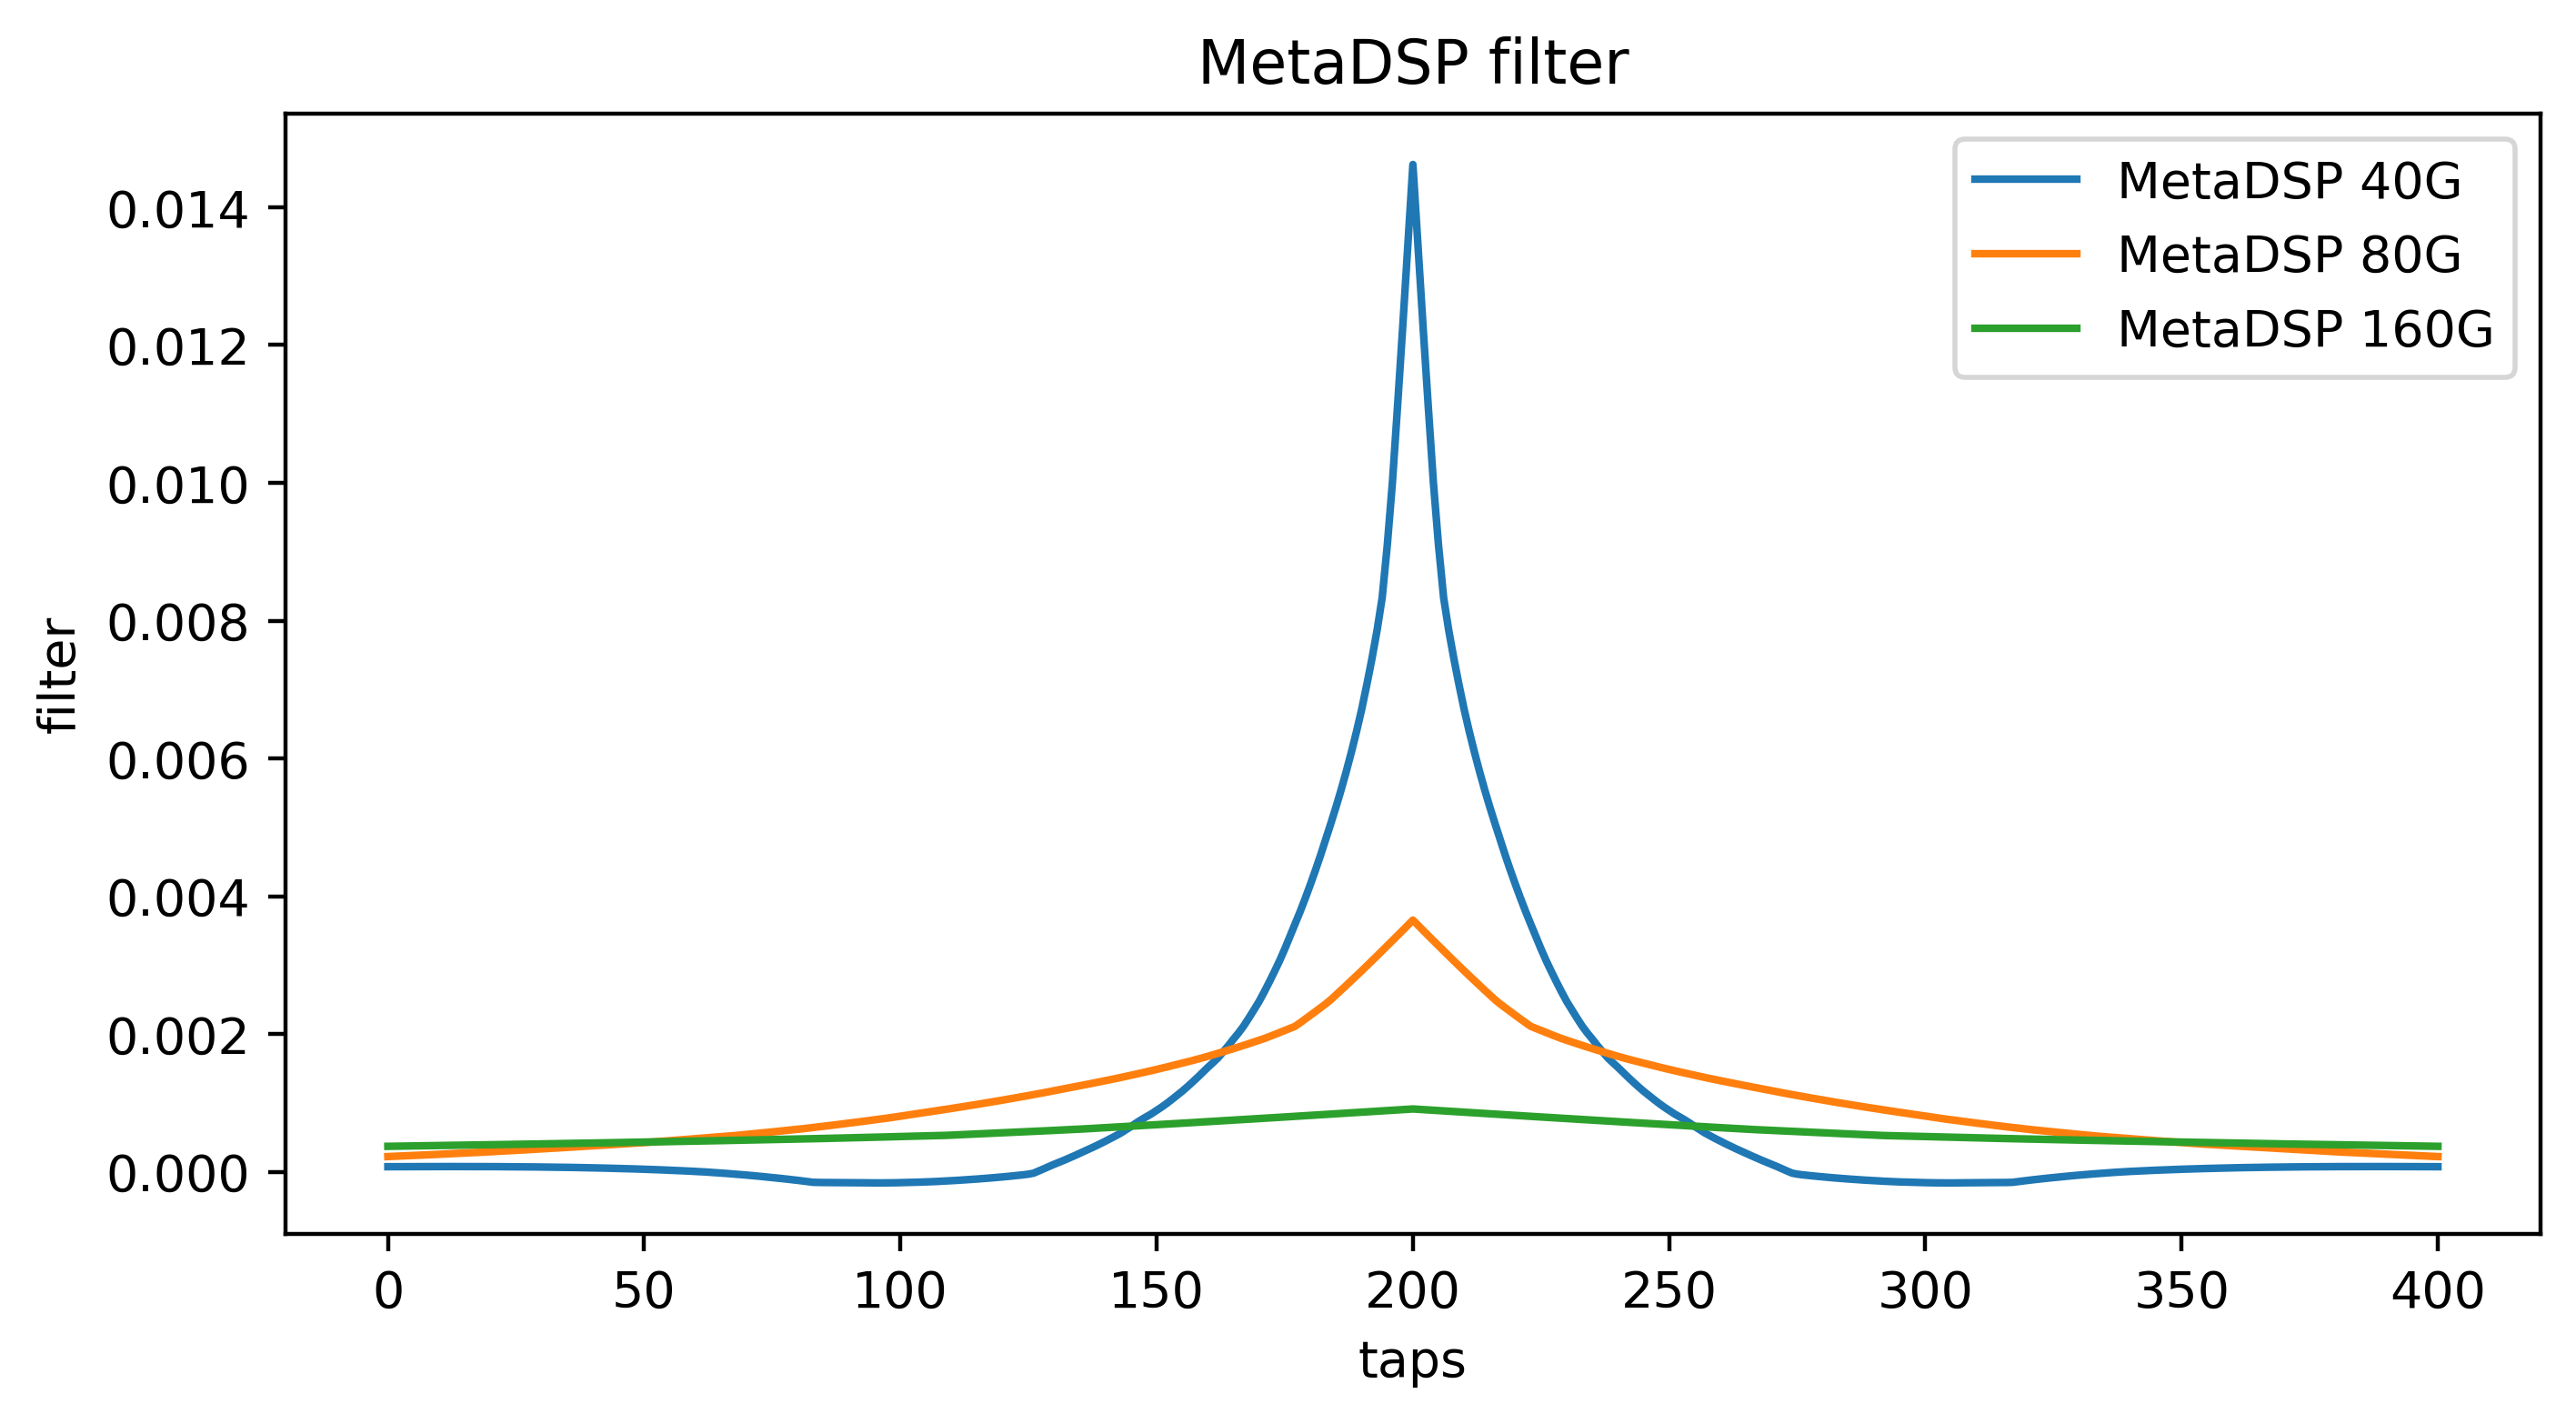

In [83]:
plt.figure(figsize=(8,4), dpi=400)
plt.plot(get_MetaDSP_Nfilter(2, 5, 40)[0,0], label='MetaDSP 40G')
plt.plot(get_MetaDSP_Nfilter(2, 5, 80)[0,0], label='MetaDSP 80G')
plt.plot(get_MetaDSP_Nfilter(2, 5, 160)[0,0], label='MetaDSP 160G')
plt.xlabel('taps')
plt.ylabel('filter')
plt.title('MetaDSP filter')
plt.legend()
plt.savefig('_outputs/R1_img/MetaDSP_Rs.png')


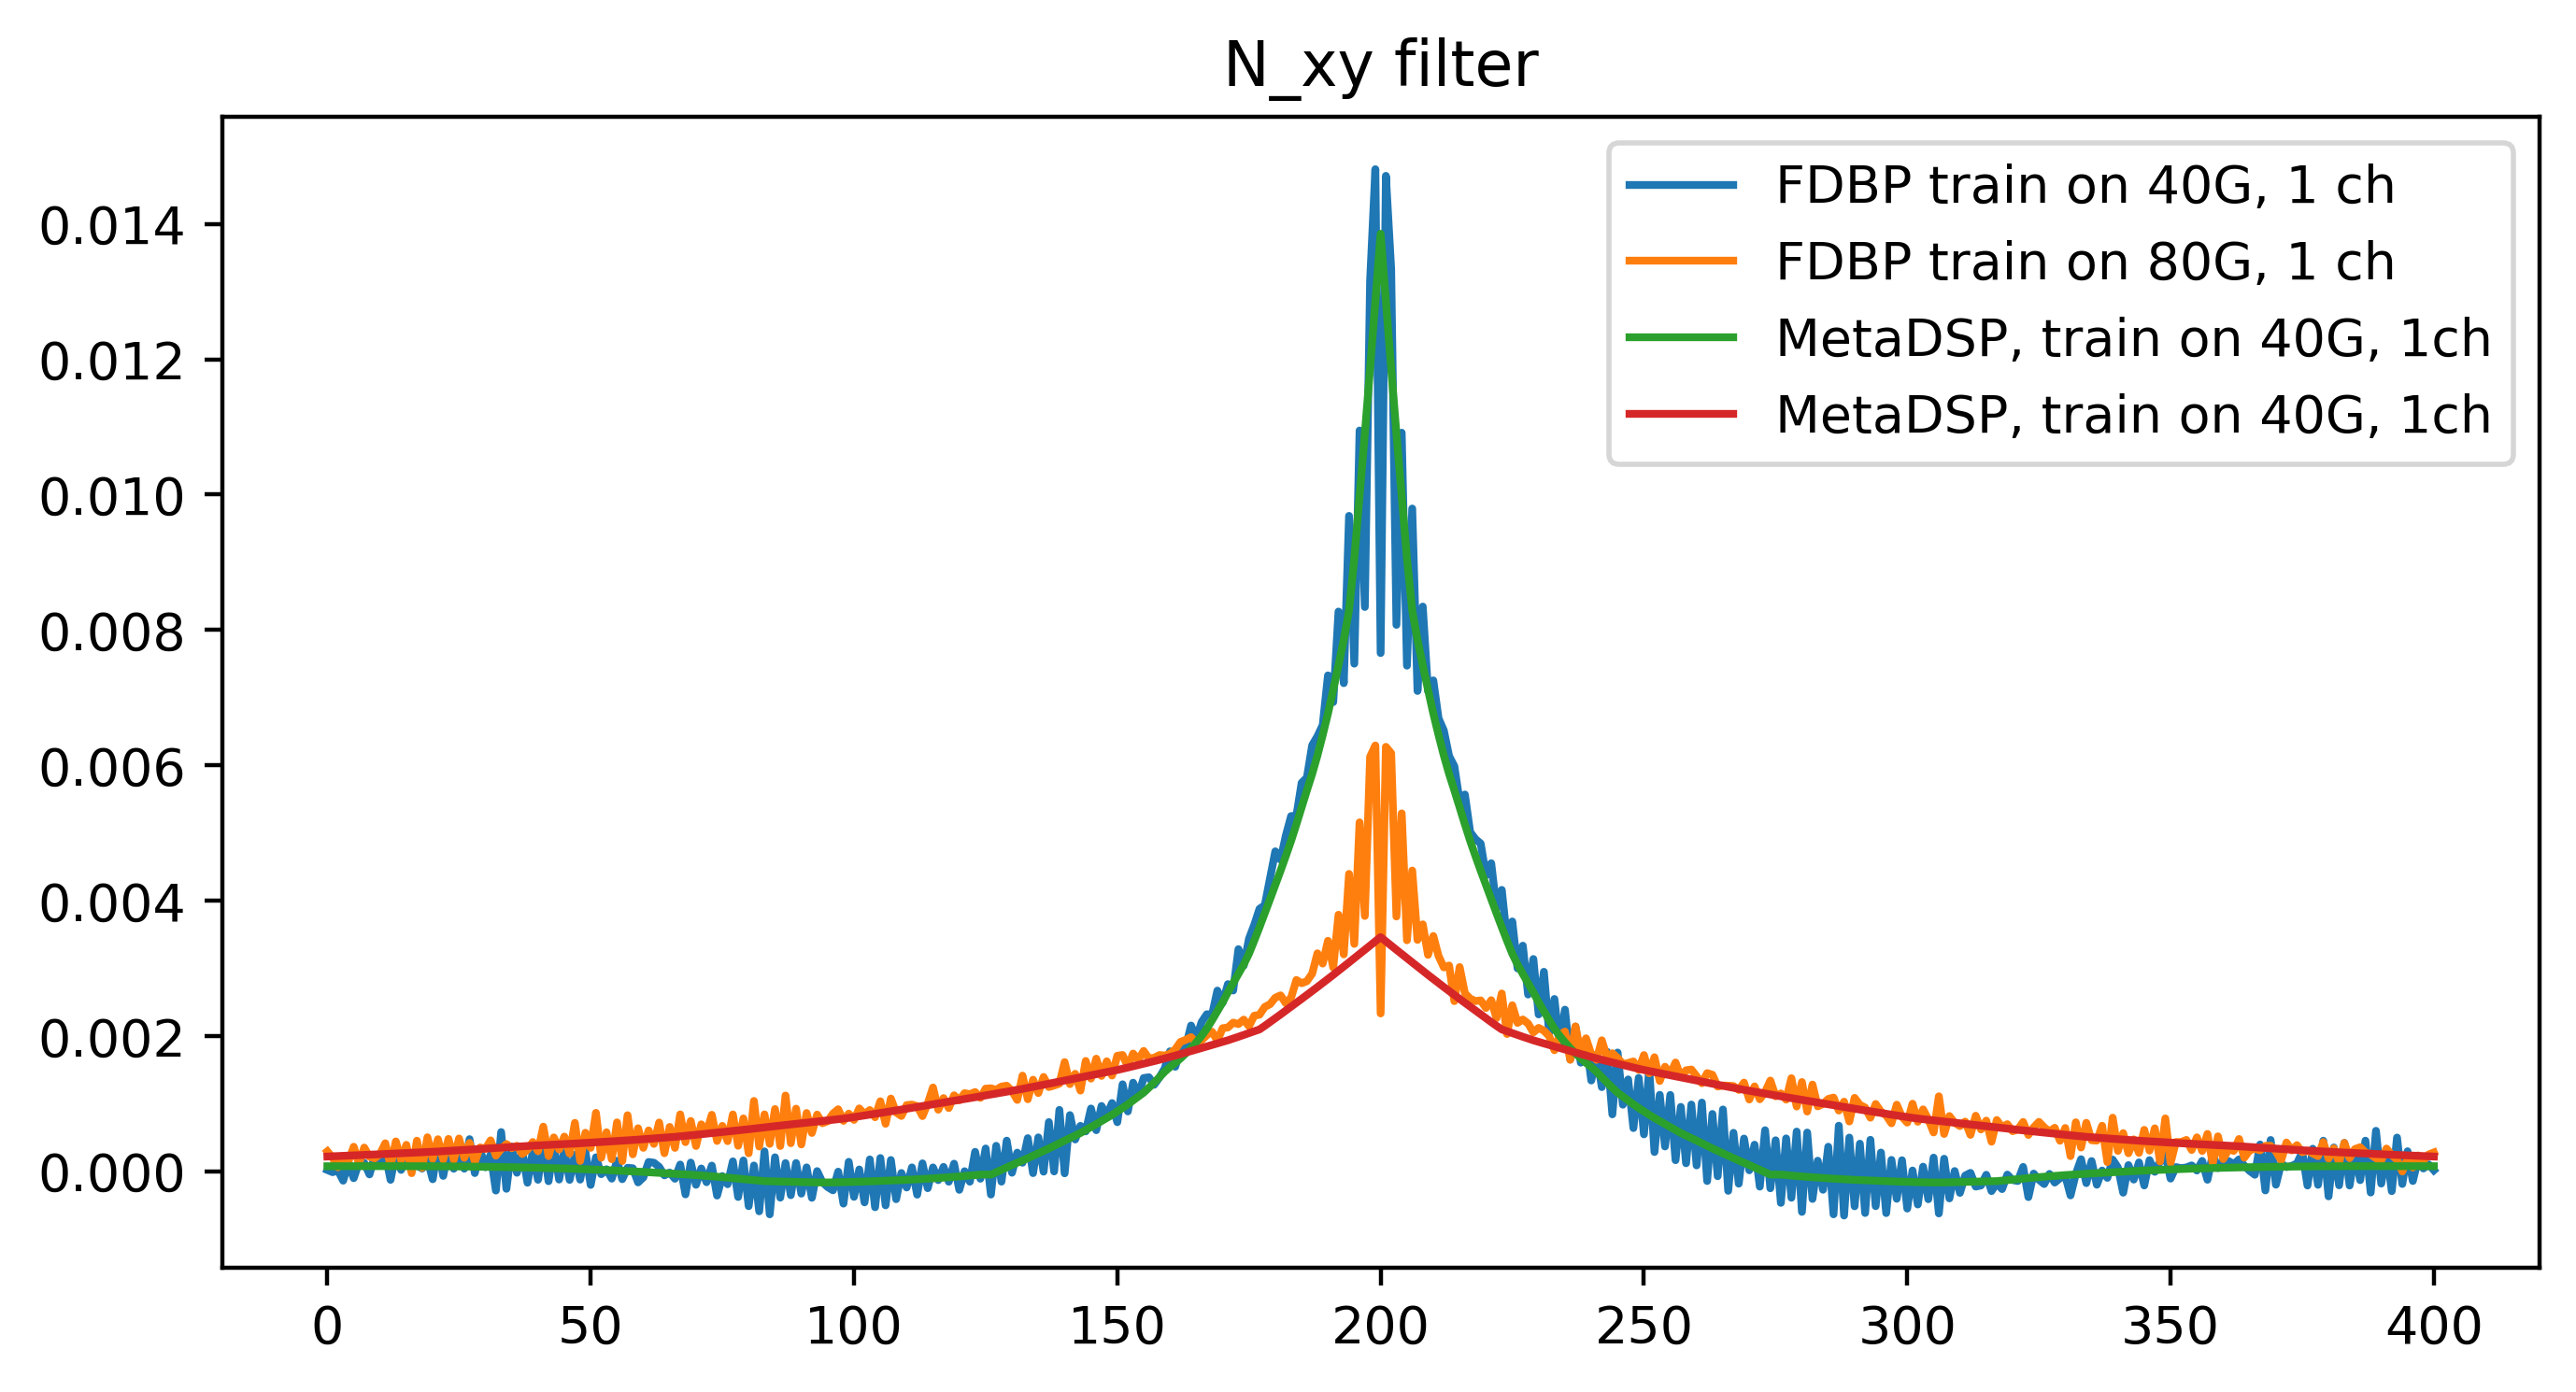

In [86]:
plt.figure(figsize=(8,4), dpi=400)
plt.plot(get_FDBP_Nfilter(2,5,40,1)[1,1], label='FDBP train on 40G, 1 ch')
plt.plot(get_FDBP_Nfilter(2,5,80,1)[1,1], label='FDBP train on 80G, 1 ch')

plt.plot(get_MetaDSP_Nfilter(2, 5, 40)[1,1], label='MetaDSP, train on 40G, 1ch')
plt.plot(get_MetaDSP_Nfilter(2, 5, 80)[1,1], label='MetaDSP, train on 40G, 1ch')

plt.title('N_xy filter')
plt.legend()
plt.savefig('_outputs/R1_img/MetaDSP_FDBP_Nxx.png')

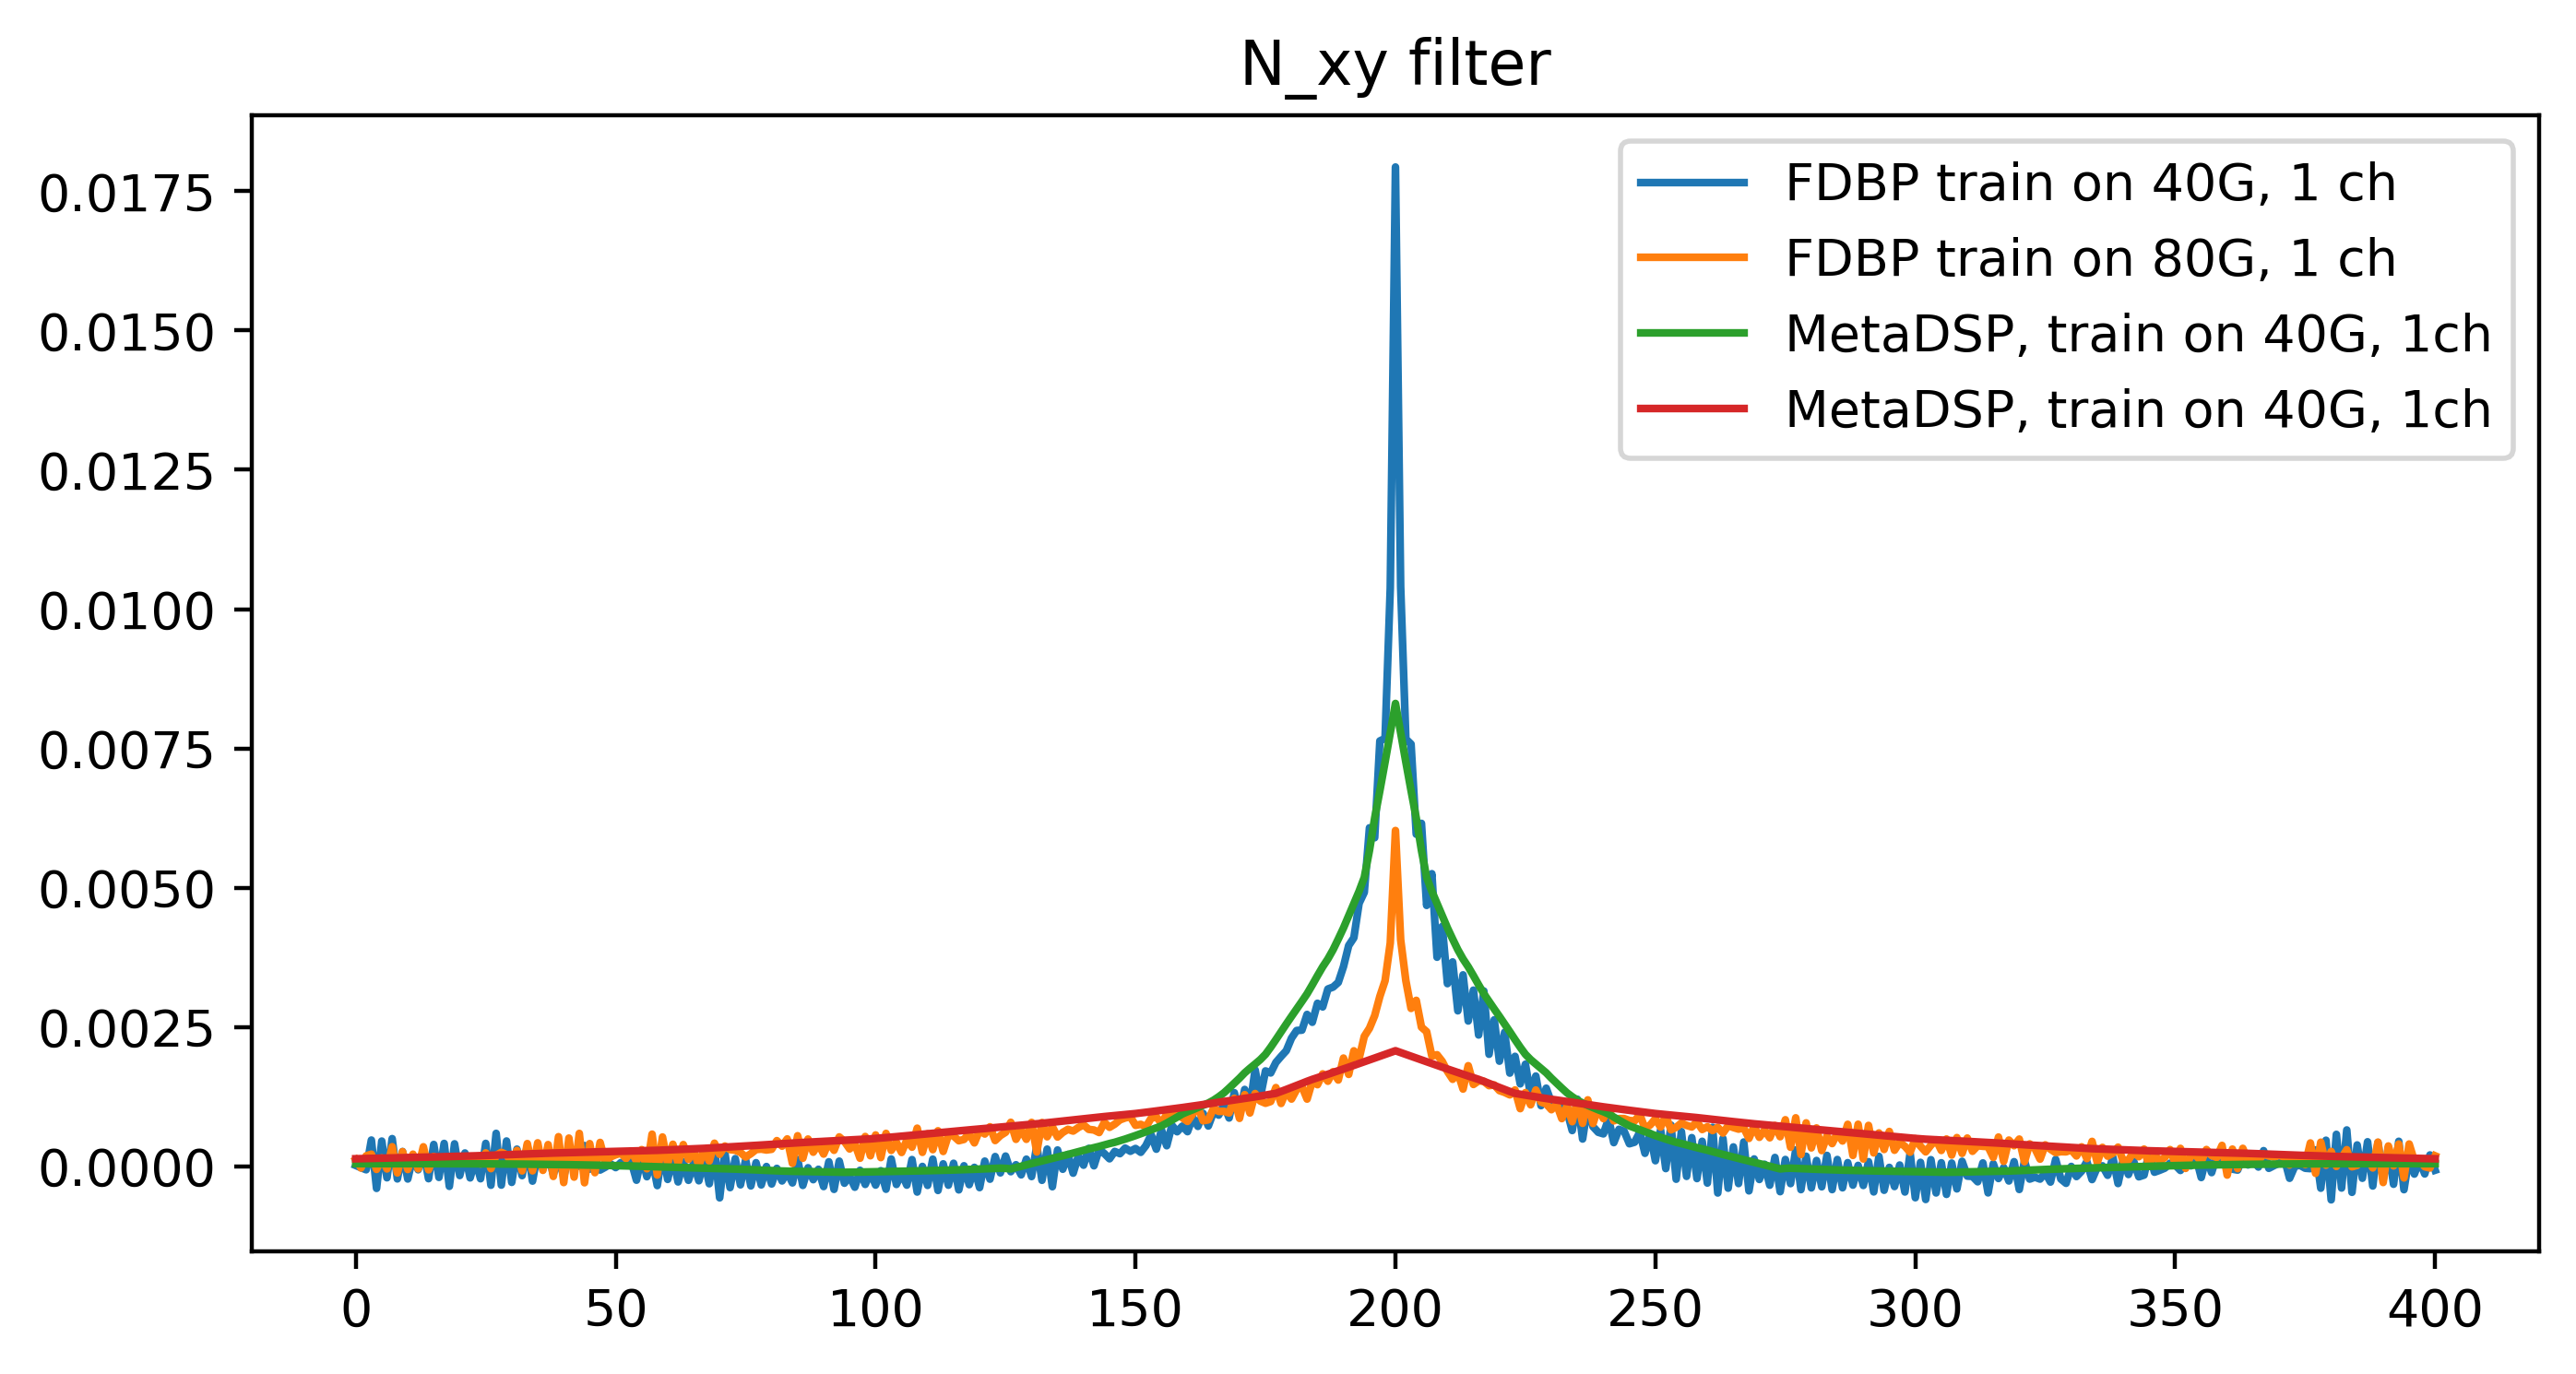

In [85]:
plt.figure(figsize=(8,4), dpi=400)
plt.plot(get_FDBP_Nfilter(2,5,40,1)[0,1], label='FDBP train on 40G, 1 ch')
plt.plot(get_FDBP_Nfilter(2,5,80,1)[0,1], label='FDBP train on 80G, 1 ch')

plt.plot(get_MetaDSP_Nfilter(2, 5, 40)[0,1], label='MetaDSP, train on 40G, 1ch')
plt.plot(get_MetaDSP_Nfilter(2, 5, 80)[0,1], label='MetaDSP, train on 40G, 1ch')

plt.title('N_xy filter')
plt.legend()
plt.savefig('_outputs/R1_img/MetaDSP_FDBP_Nxy.png')

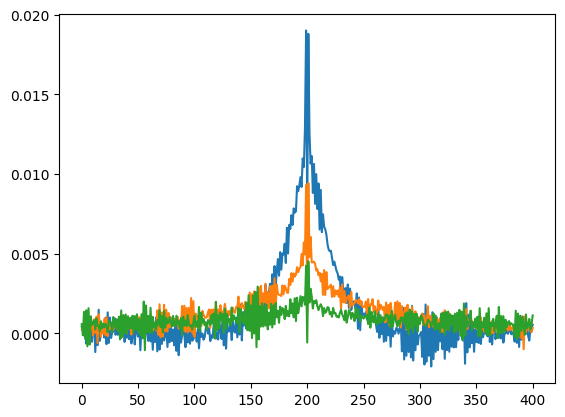

In [21]:
plt.plot(get_FDBP_Nfilter(1,5,40,1))
plt.plot(get_FDBP_Nfilter(1,5,80,1))
plt.plot(get_FDBP_Nfilter(1,5,160,1))

## plot Q-CC

## 对比实验

In [119]:
Rx,Tx,info = get_data(1, 160, 4, 1, 80000)


NameError: name 'get_data' is not defined